In [1]:
from functions import *

2024-11-25 09:07:51.335633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 09:07:51.356042: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 09:07:51.362252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 09:07:51.379057: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 09:07:52.543707: W tensorflow/compiler/tf2

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import rasterio
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pyproj
from geopandas.tools import sjoin
from shapely.geometry import Point
import requests
from scipy.stats import ks_2samp
import shutil
from matplotlib.colors import LogNorm
from rasterio.windows import Window
from rasterio.features import rasterize
from rasterio.transform import from_bounds

# Load data

#### Load raw data paths

In [3]:
W = 128
source_path = '../data/raw/'
data_paths = ['lst','ndvi']#, 'ndvi', 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {}
for i,dir_p in enumerate(dir_paths):
    all_dir_paths[data_paths[i]] = []
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p:
            if not files and not dirs:
                os.rmdir(subdir)
            else:
                all_dir_paths[data_paths[i]].append(subdir)
        #data, times = load_data(dir_paths,W,list_rgb)
all_dir_paths

{'lst': ['../data/raw/lst/cell_67',
  '../data/raw/lst/cell_2',
  '../data/raw/lst/cell_70',
  '../data/raw/lst/cell_31',
  '../data/raw/lst/cell_19',
  '../data/raw/lst/cell_29',
  '../data/raw/lst/cell_71',
  '../data/raw/lst/cell_49',
  '../data/raw/lst/cell_43',
  '../data/raw/lst/cell_10',
  '../data/raw/lst/cell_13',
  '../data/raw/lst/cell_41',
  '../data/raw/lst/cell_21',
  '../data/raw/lst/cell_11',
  '../data/raw/lst/cell_58',
  '../data/raw/lst/cell_56',
  '../data/raw/lst/cell_74',
  '../data/raw/lst/cell_37',
  '../data/raw/lst/cell_62',
  '../data/raw/lst/cell_72',
  '../data/raw/lst/cell_65',
  '../data/raw/lst/cell_8',
  '../data/raw/lst/cell_80',
  '../data/raw/lst/cell_68',
  '../data/raw/lst/cell_9',
  '../data/raw/lst/cell_18',
  '../data/raw/lst/cell_69',
  '../data/raw/lst/cell_3',
  '../data/raw/lst/cell_46',
  '../data/raw/lst/cell_23',
  '../data/raw/lst/cell_28',
  '../data/raw/lst/cell_33',
  '../data/raw/lst/cell_54',
  '../data/raw/lst/cell_76',
  '../data/

In [4]:
dir_path = '../data/raw/wt'
water_temp = pd.read_csv(f'{dir_path}/water_temp.csv', index_col=0)
water_temp

1      2     3      4      5      6      7      8  \
Zeitstempel                                                                  
2013-03-01 00:00:00   5.76   1.05  2.72   2.91   3.61   5.86   3.23   7.46   
2013-04-01 00:00:00   8.16   3.23  3.62   5.43   5.91   8.54   5.20   8.94   
2013-05-01 00:00:00  12.06   5.38  4.49   6.83   8.68  12.21   8.49   9.46   
2013-06-01 00:00:00  15.15   9.05  5.01   8.56  12.00  15.21  12.85  10.42   
2013-07-01 00:00:00  19.52  12.63  6.34  10.80  15.42  21.28  17.35  11.98   
...                    ...    ...   ...    ...    ...    ...    ...    ...   
2024-05-01 00:00:00  13.94   6.03  4.81   7.26  10.67  13.85  11.10  10.58   
2024-06-01 00:00:00  16.58   9.45  5.38   8.63  13.05  17.00  13.57  11.62   
2024-07-01 00:00:00  19.75  12.10  6.82  10.47  15.52  20.68  16.94  12.39   
2024-08-01 00:00:00  21.82  14.09  7.55  12.48  16.50  23.24  18.44  13.35   
2024-09-01 00:00:00  18.45  10.32  5.91   9.56  12.78  19.08  13.64  11.79   

                         9     10  ...     72     73     74     75     76  \
Zeitstempel                        ...                                      
2013-03-01 00:00:00   6.24   5.59  ...   5.96   8.20   4.04   6.69   6.04   
2013-04-01 00:00:00   8.94   8.33  ...   8.02   9.92   5.92   9.93   8.77   
2013-05-01 00:00:00  10.16  11.65  ...   8.53  10.93   6.86  13.71  10.15   
2013-06-01 00:00:00  13.67  15.12  ...  10.90  12.93   8.49  17.17  14.04   
2013-07-01 00:00:00  19.61  20.50  ...  13.75  16.97  10.80  20.67  20.99   
...                    ...    ...  ...    ...    ...    ...    ...    ...   
2024-05-01 00:00:00  12.20  13.40  ...  10.36  12.10   7.63  15.62  12.29   
2024-06-01 00:00:00  15.24  16.79  ...  12.24  13.55   9.03  18.39  15.95   
2024-07-01 00:00:00  18.90  20.38  ...  14.30  15.95  10.74  20.82  19.92   
2024-08-01 00:00:00  22.41  22.75  ...  16.34  17.93  11.85  21.27  23.87   
2024-09-01 00:00:00  16.21  18.08  ...  12.46  14.41   9.55  17.76  16.90   

                        77     78     79     80      81  
Zeitstempel                                              
2013-03-01 00:00:00   6.06   5.48   3.83   4.64    0.96  
2013-04-01 00:00:00   8.77   8.22   8.19   8.90    1.56  
2013-05-01 00:00:00  12.35  10.14  10.75  11.26    1.31  
2013-06-01 00:00:00  15.36  13.41  13.63  15.18    1.31  
2013-07-01 00:00:00  21.30  17.45  17.22  20.13    1.25  
...                    ...    ...    ...    ...     ...  
2024-05-01 00:00:00  13.95  11.97  12.41  14.02    1.79  
2024-06-01 00:00:00  17.04  14.46  14.65  16.51    1.56  
2024-07-01 00:00:00  20.67  17.49  17.22  19.97   Lücke  
2024-08-01 00:00:00  23.25  18.12  18.68  21.36  223.36  
2024-09-01 00:00:00  19.28  14.64  15.01  15.49    0.19  

[139 rows x 81 columns]

In [5]:
water_temp.index = pd.to_datetime(water_temp.index).strftime('%Y-%m')

In [6]:
dir_path = '../data/raw/disch'
discharge = pd.read_csv(f'{dir_path}/discharge.csv', index_col=0)
discharge

1        2      3       4         5   6        7  \
Zeitstempel                                                                  
2013-03-01 00:00:00   3.834  241.330  0.370   7.524   789.141 NaN   61.336   
2013-04-01 00:00:00  13.225  494.202  1.263  25.170  1242.046 NaN  146.108   
2013-05-01 00:00:00  34.581  481.324  2.839  39.725  1534.415 NaN  203.023   
2013-06-01 00:00:00  49.038  555.743  4.844  53.951  2078.567 NaN  263.358   
2013-07-01 00:00:00  49.649  328.907  3.820  28.298  1278.919 NaN  188.776   
...                     ...      ...    ...     ...       ...  ..      ...   
2024-05-01 00:00:00  40.826  414.496  3.753  38.421  1409.133 NaN  206.337   
2024-06-01 00:00:00  74.990  529.848  6.792  56.341  2234.300 NaN  289.505   
2024-07-01 00:00:00  66.826  412.620  4.972  27.925  1706.039 NaN  263.186   
2024-08-01 00:00:00  30.392  305.790  1.691  11.206  1012.719 NaN  208.326   
2024-09-01 00:00:00  21.467  333.607  1.501  19.832   962.979 NaN  165.468   

                          8      9       10  ...       67       68      69  \
Zeitstempel                                  ...                             
2013-03-01 00:00:00  10.462  2.540  278.162  ...   77.258  251.300  10.027   
2013-04-01 00:00:00  14.393  5.024  320.034  ...  104.718  412.565  10.138   
2013-05-01 00:00:00  10.223  5.075  521.190  ...  161.314  496.318  12.847   
2013-06-01 00:00:00   8.535  8.664  779.648  ...  220.030  547.048  22.801   
2013-07-01 00:00:00   3.332  2.165  555.155  ...  119.553  498.051  10.907   
...                     ...    ...      ...  ...      ...      ...     ...   
2024-05-01 00:00:00   6.453  5.990  498.208  ...  133.785  382.467  13.655   
2024-06-01 00:00:00   7.493  9.641  893.374  ...  233.992  610.775  19.860   
2024-07-01 00:00:00   4.156  6.010  789.944  ...  150.107  662.264  13.512   
2024-08-01 00:00:00   2.162  1.621  431.492  ...   68.495  478.604   9.515   
2024-09-01 00:00:00   6.632  3.873  314.758  ...   84.378  397.724  12.165   

                        70       71       72        73       74      75  \
Zeitstempel                                                               
2013-03-01 00:00:00  1.997  159.477  101.443   387.390  105.679  12.149   
2013-04-01 00:00:00  1.775  366.584  141.716   732.260  226.698  27.070   
2013-05-01 00:00:00  1.947  378.951  250.523   868.901  291.301  22.402   
2013-06-01 00:00:00  4.798  435.299  337.491  1120.716  339.567  25.792   
2013-07-01 00:00:00  0.708  266.880  337.819   644.033  224.320   7.271   
...                    ...      ...      ...       ...      ...     ...   
2024-05-01 00:00:00  1.995  324.285  260.007   769.702  237.402  21.262   
2024-06-01 00:00:00  3.494  412.651  457.059  1151.792  336.151  22.075   
2024-07-01 00:00:00  1.393  336.097  475.067   820.925  284.955  15.027   
2024-08-01 00:00:00  0.426  254.383  394.565   520.790  221.783   8.580   
2024-09-01 00:00:00  0.457  266.322  246.177   558.287  201.420  14.609   

                          76  
Zeitstempel                   
2013-03-01 00:00:00   79.588  
2013-04-01 00:00:00  149.656  
2013-05-01 00:00:00  237.434  
2013-06-01 00:00:00  332.866  
2013-07-01 00:00:00  203.237  
...                      ...  
2024-05-01 00:00:00  211.573  
2024-06-01 00:00:00  341.667  
2024-07-01 00:00:00  244.022  
2024-08-01 00:00:00  141.286  
2024-09-01 00:00:00  140.717  

[139 rows x 76 columns]

In [7]:
discharge.index = pd.to_datetime(discharge.index).strftime('%Y-%m')

#### Load images and times

In [8]:
t=[]
total_data = {}
total_times = {}

In [9]:
# Load input data
time_split=False
for k,v in all_dir_paths.items():
    
    if k != 'discharge' and k != 'slope' and k != 'altitude':
        print('Doing',k)
        if k == 'lst' or k == 'masked':
            list_rgb = [True]*len(v)
        else:
            list_rgb = [False]*len(v)
            
        data, times = load_data(v,W,list_rgb)
    
        labels = []
        for ki,value in data.items():
            labels+=[ki.split('/')[-1]]*len(value)
        
        data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
        times_list = [t for sublist in times for t in sublist]
        
        if time_split:
            dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
            pairs = sorted(zip(dates, data_values, labels), key=lambda x: x[0])
            sorted_dates, data_values, labels = zip(*pairs)
            times_list = [date.strftime('%Y-%m') for date in sorted_dates]
            
        total_data[k] = np.array(data_values)
        total_times[k] = times_list
        print(k,':' ,total_data[k].shape)

Doing lst
lst : (11259, 128, 128, 3)
Doing ndvi


/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


ndvi : (11259, 128, 128)


In [10]:
total_cells = []
for v in all_dir_paths['lst']:
    cell = v.split('/')[-1]
    total_cells.extend([cell]*len(times[0]))

In [11]:
lst = total_data['lst']
ndvi = total_data['ndvi']
#data_targets = total_data['wt']
#wt_stations = data[dir_paths[3]]
print('inputs shape:', lst.shape,ndvi.shape)
#print('targets shape:', data_targets.shape)

inputs shape: (11259, 128, 128, 3) (11259, 128, 128)


In [12]:
time_slots = [el for t in times for el in t]
time_slots = np.array(time_slots)
time_slots

array(['2013-03', '2013-04', '2013-05', ..., '2024-07', '2024-08',
       '2024-09'], dtype='<U7')

In [13]:
len(time_slots)

11259

#### Load rivers

In [8]:
import os
import fiona
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from shapely.ops import unary_union

river_cells = {}
output_directory = '../data/external/shp/river_cells_oficial'
a=0

for i,riv in enumerate(os.listdir(output_directory)):
    # Check if the file is a shapefile
    try:
        if riv.endswith('.shp'):
            a+=1
            print(f"Processing file: {riv}")
            river = gpd.read_file(os.path.join(output_directory, riv))
            river = river.to_crs("EPSG:4326")
            river_cells[riv.split('station_')[-1].split('.')[0]] = river
            print('Added', riv.split('station_')[-1].split('.')[0])

    except Exception as e:
        print(f"Error processing file: {riv}",e)
        pass
        

Processing file: station_cell_37.shp
Added cell_37
Processing file: station_cell_8.shp
Added cell_8
Processing file: station_cell_33.shp
Added cell_33
Processing file: station_cell_9.shp
Added cell_9
Processing file: station_cell_42.shp
Added cell_42
Processing file: station_cell_78.shp
Added cell_78
Processing file: station_cell_6.shp
Added cell_6
Processing file: station_cell_46.shp
Added cell_46
Processing file: station_cell_31.shp
Added cell_31
Processing file: station_cell_59.shp
Added cell_59
Processing file: station_cell_63.shp
Added cell_63
Processing file: station_cell_11.shp
Added cell_11
Processing file: station_cell_36.shp
Added cell_36
Processing file: station_cell_65.shp
Added cell_65
Processing file: station_cell_56.shp
Added cell_56
Processing file: station_cell_12.shp
Added cell_12
Processing file: station_cell_72.shp
Added cell_72
Processing file: station_cell_24.shp
Added cell_24
Processing file: station_cell_38.shp
Added cell_38
Processing file: station_cell_80.shp


In [15]:
river_cells['cell_31'].shape

(3213, 24)

# Delete unuseful data

In [16]:
del_indices = set()
fixed_ndvi = []
test_index = 0
for index in range(0,lst.shape[0]):
  # Obtain percentage of black and white pixels of lst
  print('imatge', index)
  for k in total_data.keys():
    if k != 'wt':
        print('fent', k)
        if len(total_data[k][index].shape) == 2:
          img_gray = total_data[k][index]
        else:
          img_gray = np.dot(total_data[k][index][...,:3], [0.2989, 0.5870, 0.1140])
        
        blacks = img_gray==0
        percentage_b = np.sum(blacks)/blacks.size * 100
        whites = img_gray>=240
        percentage_w = np.sum(whites)/whites.size * 100
        num_nans = np.sum(np.isnan(img_gray))
        percentage_nans = (num_nans*100)/(img_gray.size)
        print('tinc ',num_nans,' sobre ',img_gray.size,' ocupen un percentatge', percentage_nans)
        conditions = [np.all(img_gray == img_gray[0, 0]), percentage_b > 50, percentage_w > 50,np.all(np.isnan(img_gray)), percentage_nans > 50]
        
        if True in conditions:
            del_indices.add(index)
            break
        elif k == 'ndvi':
            new_ndvi = np.where(np.isnan(total_data[k][index]), 0.0, total_data[k][index])
            fixed_ndvi.append(new_ndvi)
  print()
  

imatge 0
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 1
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0
fent ndvi
tinc  14245  sobre  16384  ocupen un percentatge 86.944580078125

imatge 2
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 3
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0
fent ndvi
tinc  16384  sobre  16384  ocupen un percentatge 100.0

imatge 4
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 5
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0
fent ndvi
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 6
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 7
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 8
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 9
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 10
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0
fent ndvi
tinc  11774  sobre  16384  ocupen un percen

In [17]:
fixed_ndvi = np.array(fixed_ndvi)

In [18]:
slots = np.delete(time_slots,list(del_indices))

In [19]:
len(slots)

1654

In [20]:
clean_cells = np.delete(np.array(total_cells),list(del_indices))
len(clean_cells)

1654

In [21]:
len(fixed_ndvi)

1654

### Clean water temperature data

In [22]:
wt_values = pd.DataFrame(columns=["Cell", "Date", "WaterTemp"])
del_cells={}
for count in range(len(clean_cells)):
    keep_cell = clean_cells[count]
    keep_date = slots[count]
    temp_value = water_temp.loc[keep_date][keep_cell.split('_')[-1]]

    # Comprobar si temp_value no es 'Lücke' y es un número válido
    if temp_value != 'Lücke' and isinstance(temp_value, (int, float)) and not np.isnan(temp_value):
        new_row = pd.DataFrame({"Cell": [keep_cell], "Date": [keep_date], "WaterTemp": [temp_value]})
        wt_values = pd.concat([wt_values, new_row], ignore_index=True)
    elif isinstance(temp_value, str) and temp_value.replace('.', '', 1).isdigit():
        # Convertir temp_value a float si es una cadena numérica
        new_row = pd.DataFrame({"Cell": [keep_cell], "Date": [keep_date], "WaterTemp": [float(temp_value)]})
        wt_values = pd.concat([wt_values, new_row], ignore_index=True)
    else:
        # Si el valor no es numérico o es 'Lücke', añadirlo a del_cells
        if keep_cell not in del_cells:
            del_cells[keep_cell] = [keep_date]
        else:
            del_cells[keep_cell].append(keep_date)
        print('hola', temp_value, keep_cell, keep_date)

del_cells

/tmp/ipykernel_1188307/1651386172.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wt_values = pd.concat([wt_values, new_row], ignore_index=True)


hola nan cell_70 2013-12
hola nan cell_70 2014-03
hola nan cell_70 2014-04
hola nan cell_70 2014-08
hola nan cell_70 2015-08
hola nan cell_70 2017-06
hola nan cell_70 2017-10
hola nan cell_70 2017-11
hola nan cell_70 2017-12
hola nan cell_70 2018-04
hola nan cell_70 2018-06
hola nan cell_70 2018-08
hola nan cell_70 2019-01
hola nan cell_70 2019-09
hola nan cell_70 2020-05
hola nan cell_70 2021-01
hola nan cell_70 2021-06
hola nan cell_70 2021-09
hola nan cell_70 2021-10
hola nan cell_70 2022-02
hola nan cell_70 2022-08
hola nan cell_70 2022-09
hola nan cell_70 2023-02
hola nan cell_70 2023-03
hola nan cell_70 2024-02
hola Lücke cell_81 2024-07


{'cell_70': ['2013-12',
  '2014-03',
  '2014-04',
  '2014-08',
  '2015-08',
  '2017-06',
  '2017-10',
  '2017-11',
  '2017-12',
  '2018-04',
  '2018-06',
  '2018-08',
  '2019-01',
  '2019-09',
  '2020-05',
  '2021-01',
  '2021-06',
  '2021-09',
  '2021-10',
  '2022-02',
  '2022-08',
  '2022-09',
  '2023-02',
  '2023-03',
  '2024-02'],
 'cell_81': ['2024-07']}

In [23]:
wt_values

Cell     Date  WaterTemp
0     cell_67  2013-08      12.22
1     cell_67  2014-02       5.91
2     cell_67  2015-05      10.48
3     cell_67  2018-06      11.84
4     cell_67  2020-03       7.41
...       ...      ...        ...
1623  cell_24  2017-06      13.46
1624  cell_24  2021-04       5.86
1625  cell_24  2021-05       7.81
1626  cell_24  2021-12       3.20
1627  cell_24  2024-09      12.00

[1628 rows x 3 columns]

In [25]:
disch_values = pd.DataFrame(columns=["Cell", "Date", "Discharge"])
for count in range(len(clean_cells)):
    keep_cell = clean_cells[count]
    keep_date = slots[count]
    if keep_cell.split('_')[-1] in discharge.columns:
        temp_value = discharge.loc[keep_date][keep_cell.split('_')[-1]]
    
        # Comprobar si temp_value no es 'Lücke' y es un número válido
        if temp_value != 'Lücke' and isinstance(temp_value, (int, float)) and not np.isnan(temp_value):
            new_row = pd.DataFrame({"Cell": [keep_cell], "Date": [keep_date], "Discharge": [temp_value]})
            disch_values = pd.concat([disch_values, new_row], ignore_index=True)
        elif isinstance(temp_value, str) and temp_value.replace('.', '', 1).isdigit():
            # Convertir temp_value a float si es una cadena numérica
            new_row = pd.DataFrame({"Cell": [keep_cell], "Date": [keep_date], "Discharge": [float(temp_value)]})
            disch_values = pd.concat([disch_values, new_row], ignore_index=True)
        else:
            # Si el valor no es numérico o es 'Lücke', añadirlo a del_cells
            if keep_cell not in del_cells:
                del_cells[keep_cell] = [keep_date]
            else:
                del_cells[keep_cell].append(keep_date)
            print('hola', temp_value, keep_cell, keep_date)
    else:
        if keep_cell not in del_cells:
            del_cells[keep_cell] = [keep_date]
        else:
            del_cells[keep_cell].append(keep_date)
            print('hola', temp_value, keep_cell, keep_date)

del_cells

/tmp/ipykernel_1188307/3665125623.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  disch_values = pd.concat([disch_values, new_row], ignore_index=True)


hola 24.492 cell_80 2013-05
hola 24.492 cell_80 2013-07
hola 24.492 cell_80 2014-04
hola 24.492 cell_80 2014-06
hola 24.492 cell_80 2014-07
hola 24.492 cell_80 2014-11
hola 24.492 cell_80 2015-02
hola 24.492 cell_80 2015-03
hola 24.492 cell_80 2015-04
hola 24.492 cell_80 2015-05
hola 24.492 cell_80 2015-08
hola 24.492 cell_80 2016-10
hola 24.492 cell_80 2016-11
hola 24.492 cell_80 2017-11
hola 24.492 cell_80 2017-12
hola 24.492 cell_80 2018-04
hola 24.492 cell_80 2018-05
hola 24.492 cell_80 2018-06
hola 24.492 cell_80 2018-08
hola 24.492 cell_80 2019-01
hola 24.492 cell_80 2019-04
hola 24.492 cell_80 2019-09
hola 24.492 cell_80 2019-11
hola 24.492 cell_80 2020-02
hola 24.492 cell_80 2020-04
hola 24.492 cell_80 2020-06
hola 24.492 cell_80 2020-07
hola 24.492 cell_80 2021-04
hola 24.492 cell_80 2021-05
hola 24.492 cell_80 2021-06
hola 24.492 cell_80 2021-07
hola 24.492 cell_80 2021-09
hola 24.492 cell_80 2021-11
hola 24.492 cell_80 2022-04
hola 24.492 cell_80 2022-06
hola 24.492 cell_80 

{'cell_70': ['2013-12',
  '2014-03',
  '2014-04',
  '2014-08',
  '2015-08',
  '2017-06',
  '2017-10',
  '2017-11',
  '2017-12',
  '2018-04',
  '2018-06',
  '2018-08',
  '2019-01',
  '2019-09',
  '2020-05',
  '2021-01',
  '2021-06',
  '2021-09',
  '2021-10',
  '2022-02',
  '2022-08',
  '2022-09',
  '2023-02',
  '2023-03',
  '2024-02'],
 'cell_81': ['2024-07',
  '2013-07',
  '2014-05',
  '2014-06',
  '2014-07',
  '2015-01',
  '2015-03',
  '2015-06',
  '2015-08',
  '2015-10',
  '2016-09',
  '2016-11',
  '2017-02',
  '2017-08',
  '2018-02',
  '2019-07',
  '2020-08',
  '2021-01',
  '2022-04',
  '2022-09',
  '2023-04',
  '2023-05',
  '2023-12',
  '2024-07',
  '2024-09'],
 'cell_80': ['2013-03',
  '2013-05',
  '2013-07',
  '2014-04',
  '2014-06',
  '2014-07',
  '2014-11',
  '2015-02',
  '2015-03',
  '2015-04',
  '2015-05',
  '2015-08',
  '2016-10',
  '2016-11',
  '2017-11',
  '2017-12',
  '2018-04',
  '2018-05',
  '2018-06',
  '2018-08',
  '2019-01',
  '2019-04',
  '2019-09',
  '2019-11',
  '

# Download preprocessed data

#### Clean preprocessed directories

In [26]:
raw_data_path = '../data/raw/'
preprocessed_data_path = '../data/preprocessed/'

data = ['lst', 'ndvi', 'wt']#,'wt_interpolated', 'lst/masked']
for d in data:
    dest_dir = os.path.join(preprocessed_data_path, d)
    os.makedirs(dest_dir, exist_ok=True)
    clear_directory(dest_dir)


In [27]:
os.makedirs('../data/preprocessed/wt',exist_ok=True)
wt_values.to_csv('../data/preprocessed/wt/water_temp.csv')

In [28]:
os.makedirs('../data/preprocessed/discharge',exist_ok=True)
disch_values.to_csv('../data/preprocessed/discharge/discharge.csv')

#### Copy preprocessed images

In [29]:
import rasterio
from rasterio.transform import from_origin, from_bounds
import numpy as np

def save_raster(raster_array, filepath, shp, resolution=30, nodata_value=0.0):
    
    resolution = 30
    x_min, y_min, x_max, y_max = shp.total_bounds
    width, height = raster_array.shape[1], raster_array.shape[0]
    resolution_x = (x_max - x_min) / width
    resolution_y = (y_max - y_min) / height

    print(width,height,raster_array.shape[0],raster_array.shape[1])
    
    #transform = from_origin(x_min, y_max, resolution, resolution)
    transform = from_bounds(x_min, y_min, x_max, y_max, width, height)

    with rasterio.open(
        filepath,
        'w',
        driver='GTiff',
        height=raster_array.shape[0],
        width=raster_array.shape[1],
        count=len(raster_array.shape),
        dtype=raster_array.dtype,
        crs=shp.crs.to_string(),  # Ensure correct CRS
        transform=transform,
        nodata=0.0
    ) as dst:
        if len(raster_array.shape) == 3:
            dst.write(raster_array[:, :, 0], 1)  # Red channel
            dst.write(raster_array[:, :, 1], 2)  # Green channel
            dst.write(raster_array[:, :, 2], 3)  # Blue channel
        else:
            dst.write(raster_array, 1)
    print(f"Raster saved to {filepath} with bounds {x_min}, {y_min}, {x_max}, {y_max}, {shp.crs.to_string()}")




In [30]:
from collections import Counter

for d, paths in all_dir_paths.items():
    count = 0
    included = 0
    imgs_per_river = Counter()
    imgs_out=0
    
    for cell_path in paths:
        try:
            source_dir = cell_path
            cell = cell_path.split('/')[-1]
            
            river = river_cells[cell]
            files = os.listdir(source_dir)
            sorted_files = sorted(files, key=extract_year_month_from_filename)

            dest_dir = os.path.join(preprocessed_data_path, f'{d}/{cell}')
            os.makedirs(dest_dir, exist_ok=True)
    
            for file in sorted_files:
                if count not in del_indices:
                    print('Cell',cell)
                    date = file.split('_')[-1].split('.')[0]
                    
                    if cell in del_cells and date in del_cells[cell]:
                            print('Not this one', cell,date)
                            count+=1
                            included+=1
                            continue
                    
                    if d == 'ndvi':
                        name = f'{dest_dir}/ndvi_{date}.tiff'
                        save_raster(fixed_ndvi[included], name, river)
                        print()
                        print(f'Copied: ndvi_{date}, at {dest_dir}')
                        print()
                    
                    else:
                        dst_path = os.path.join(dest_dir, file)
                        src_path = os.path.join(source_dir, file)
                        # Copy the file to the destination folder
                        shutil.copy(src_path, dst_path)
                        print()
                        print(f'Copied: {file}, from {src_path}, to {dst_path}')
                    included+=1
                    imgs_per_river[cell] += 1
                count+=1
                
        except Exception as e:
            print(e)
            imgs_out += len(os.listdir(source_dir))
            rr = river_cells[cell]
            print(cell)
            print()
            print('afegeixo',len(os.listdir(source_dir)), 'imatges no processades')
            count += len(os.listdir(source_dir))
            pass
        
                

Cell cell_67

Copied: image_2013-08.tiff, from ../data/raw/lst/cell_67/image_2013-08.tiff, to ../data/preprocessed/lst/cell_67/image_2013-08.tiff
Cell cell_67

Copied: image_2014-02.tiff, from ../data/raw/lst/cell_67/image_2014-02.tiff, to ../data/preprocessed/lst/cell_67/image_2014-02.tiff
Cell cell_67

Copied: image_2015-05.tiff, from ../data/raw/lst/cell_67/image_2015-05.tiff, to ../data/preprocessed/lst/cell_67/image_2015-05.tiff
Cell cell_67

Copied: image_2018-06.tiff, from ../data/raw/lst/cell_67/image_2018-06.tiff, to ../data/preprocessed/lst/cell_67/image_2018-06.tiff
Cell cell_67

Copied: image_2020-03.tiff, from ../data/raw/lst/cell_67/image_2020-03.tiff, to ../data/preprocessed/lst/cell_67/image_2020-03.tiff
Cell cell_67

Copied: image_2020-06.tiff, from ../data/raw/lst/cell_67/image_2020-06.tiff, to ../data/preprocessed/lst/cell_67/image_2020-06.tiff
Cell cell_67

Copied: image_2021-09.tiff, from ../data/raw/lst/cell_67/image_2021-09.tiff, to ../data/preprocessed/lst/cell_

In [31]:
print(np.sum(list(imgs_per_river.values())))
print(imgs_per_river)
print(imgs_out)
print(len(slots))
print(len(imgs_per_river))
print(included)

1487
Counter({'cell_33': 46, 'cell_38': 41, 'cell_63': 41, 'cell_71': 39, 'cell_28': 35, 'cell_16': 35, 'cell_31': 32, 'cell_39': 32, 'cell_34': 30, 'cell_13': 28, 'cell_46': 27, 'cell_73': 27, 'cell_37': 26, 'cell_23': 26, 'cell_17': 26, 'cell_27': 26, 'cell_74': 25, 'cell_51': 25, 'cell_29': 24, 'cell_22': 24, 'cell_12': 24, 'cell_11': 23, 'cell_9': 23, 'cell_30': 23, 'cell_56': 22, 'cell_65': 22, 'cell_68': 21, 'cell_76': 21, 'cell_57': 21, 'cell_21': 20, 'cell_7': 20, 'cell_42': 20, 'cell_53': 20, 'cell_40': 20, 'cell_66': 20, 'cell_47': 20, 'cell_19': 19, 'cell_58': 19, 'cell_72': 19, 'cell_18': 19, 'cell_20': 19, 'cell_59': 19, 'cell_75': 19, 'cell_61': 19, 'cell_55': 19, 'cell_52': 18, 'cell_4': 18, 'cell_43': 17, 'cell_54': 17, 'cell_48': 17, 'cell_14': 17, 'cell_41': 16, 'cell_62': 16, 'cell_45': 16, 'cell_2': 15, 'cell_10': 15, 'cell_26': 15, 'cell_67': 13, 'cell_35': 13, 'cell_44': 13, 'cell_25': 13, 'cell_8': 11, 'cell_69': 11, 'cell_32': 11, 'cell_5': 10, 'cell_49': 9, 'ce

CHECK

In [32]:
dir_paths = ['../data/preprocessed/lst/cell_73']
W = 128
list_rgb = [True]
data, time_slots_n = load_data(dir_paths,W,list_rgb)

(27, 128, 128, 3)
0


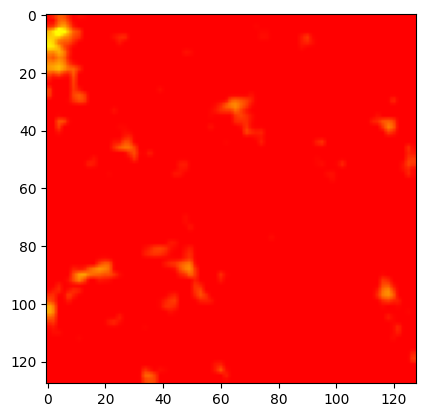

0


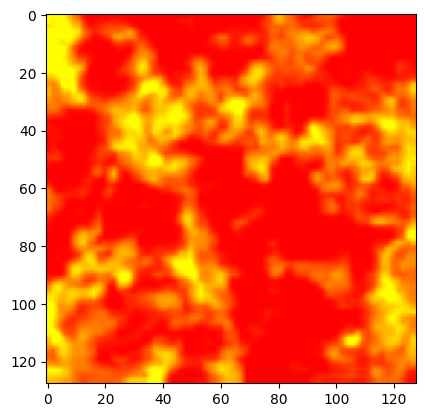

0


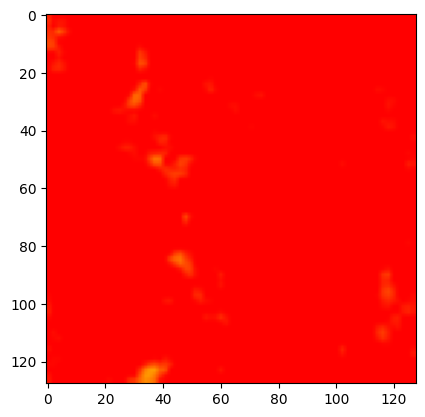

0


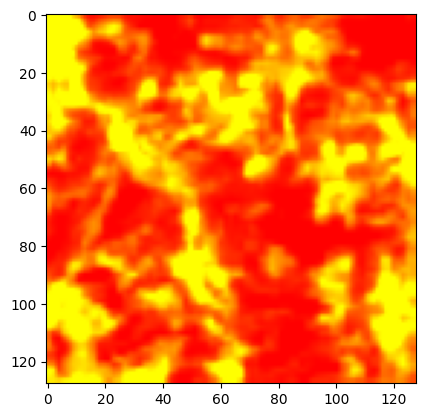

0


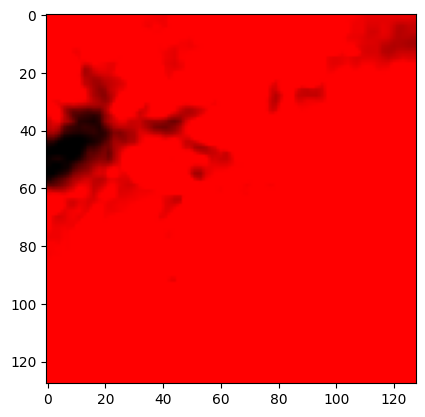

0


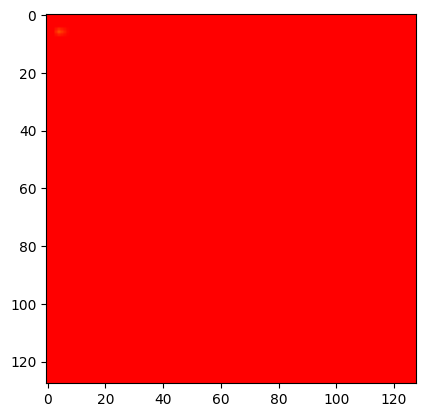

0


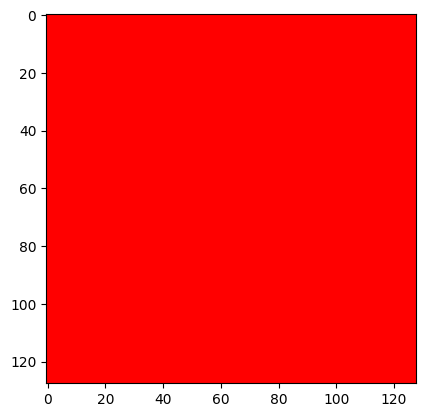

0


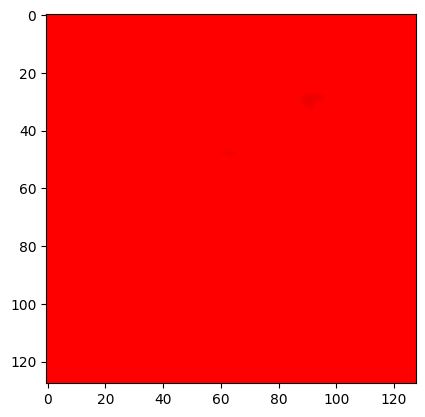

0


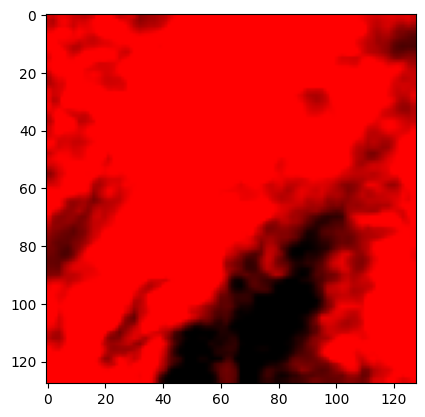

0


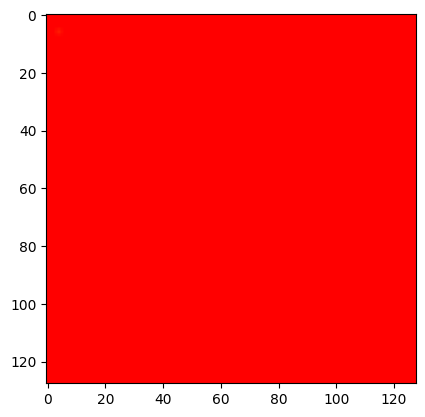

0


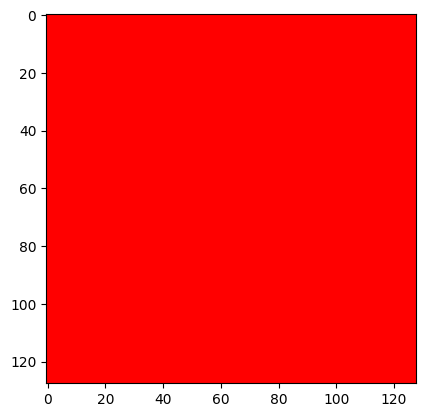

0


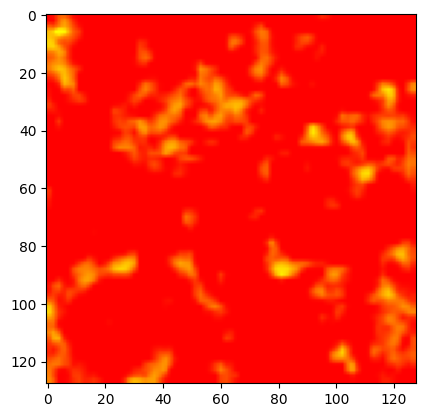

0


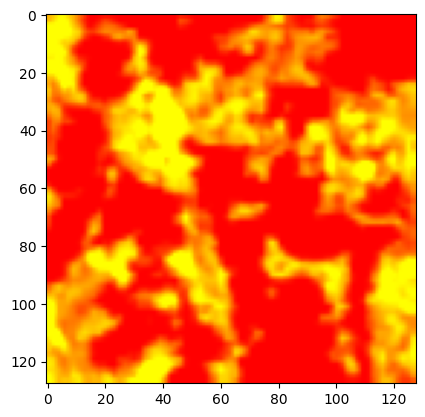

0


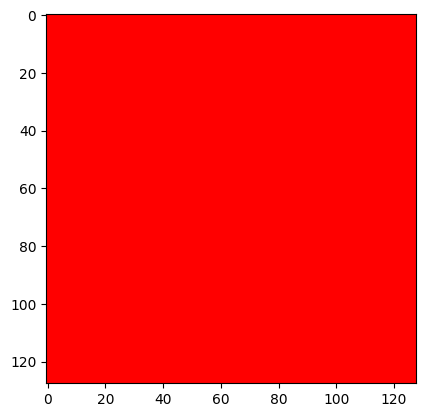

0


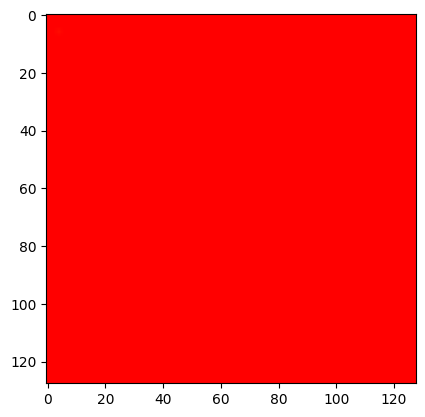

0


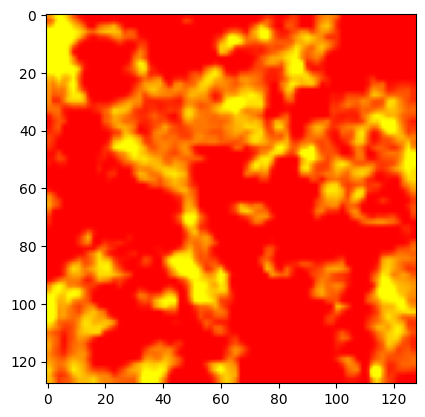

0


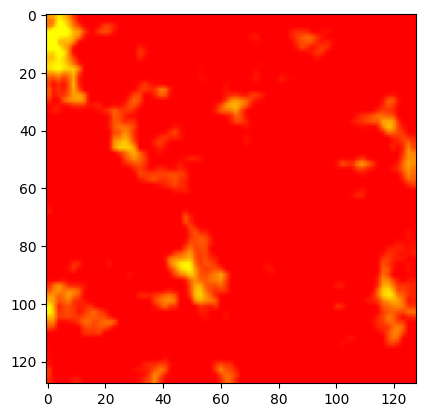

0


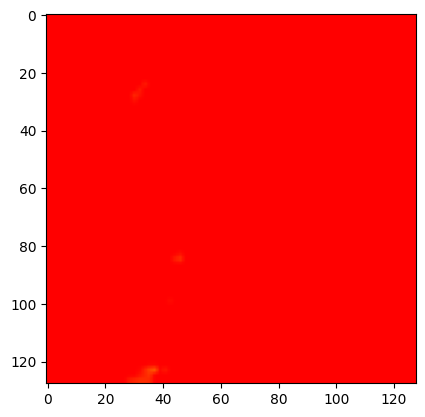

0


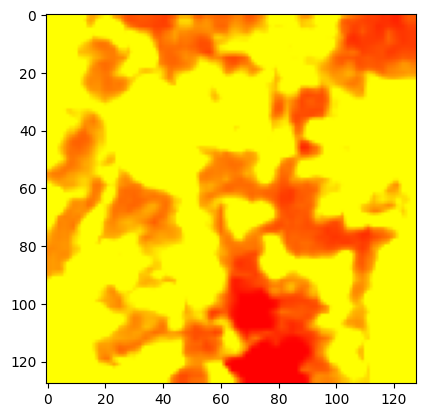

0


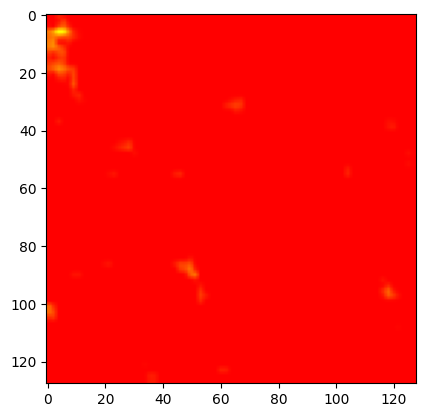

0


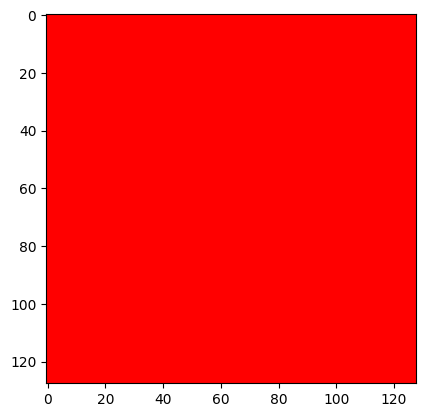

0


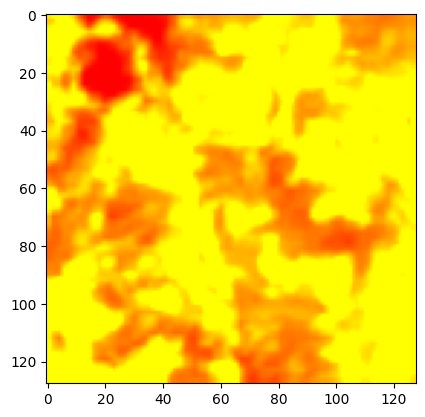

0


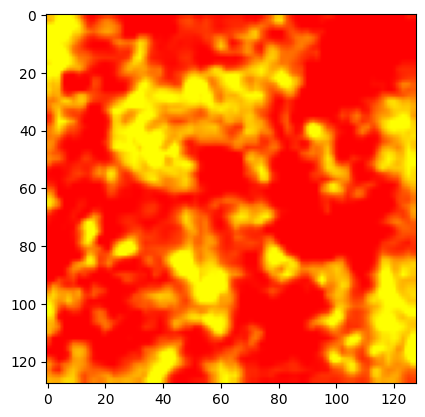

0


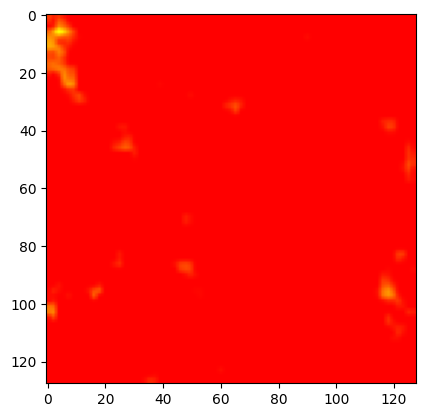

0


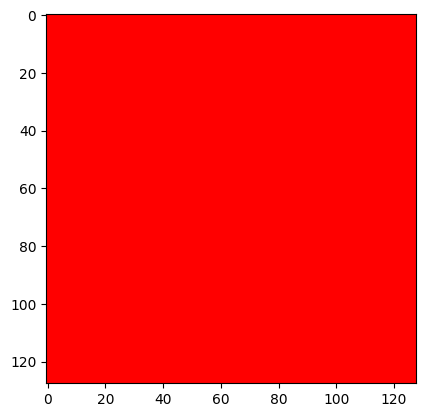

0


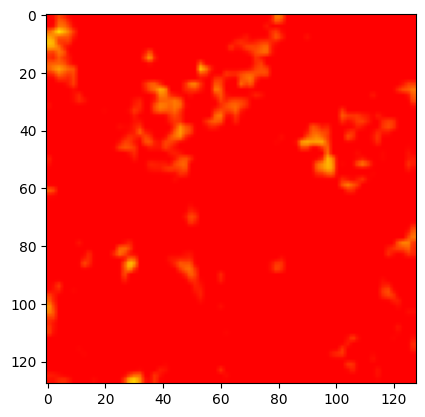

0


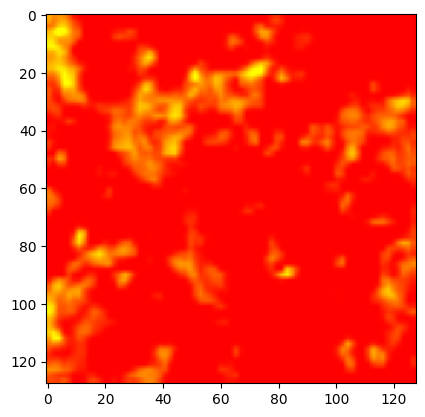

In [33]:
n = data[dir_paths[0]]
print(n.shape)
for i in n:
  print(np.sum(np.isnan(i)))
  plt.imshow(np.clip(i*(6/255),0,1))
  plt.show()

# Cut images

In [3]:
def crop_rasters_with_metadata(input_paths, output_paths, crop_size):
    """
    Crops each raster file to the central crop_size x crop_size pixel area and updates metadata to reflect new bounds.
    
    Parameters:
    input_paths (list of str): List of file paths to the input rasters.
    output_paths (list of str): List of file paths for saving cropped rasters.
    crop_size (int): Size of the central square to crop (e.g., 8 for 8x8 pixels).
    """
    for input_path, output_path in zip(input_paths, output_paths):
        print('Come from', input_path)
        print('I go to', output_path)
        with rasterio.open(input_path) as src:
            if crop_size > src.width or crop_size > src.height:
                raise ValueError(f"Crop size {crop_size}x{crop_size} exceeds raster dimensions {src.width}x{src.height}")
            
            # Define the crop window for the central crop_size x crop_size pixels
            left = (src.width - crop_size) // 2
            top = (src.height - crop_size) // 2
            window = Window(left, top, crop_size, crop_size)
            
            # Read the cropped window data
            cropped_data = src.read(window=window)
            
            # Update profile and adjust the transform to reflect the new bounds
            profile = src.profile
            profile.update({
                'width': crop_size,
                'height': crop_size,
                'transform': rasterio.windows.transform(window, src.transform)
            })
            
            # Write the cropped raster with updated metadata
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(cropped_data)


In [3]:
def load_all_data(
    source_folder='../data/external/shp/river_cells_oficial',
    source_path='../data/preprocessed/',
    data_paths=['lst', 'slope', 'discharge', 'ndvi', 'altitude'],
    filter_altitude=None,
    W=256,
    time_split=False,
):
    
    dir_paths = [os.path.join(source_path, p) for p in data_paths]
    
    all_dir_paths = {k: [] for k in data_paths}
    total_data = {}
    total_times = {}

    if not filter_altitude:
        rivers = [f.split('station_')[-1].split('.')[0] for f in os.listdir(source_folder) if os.path.join(source_folder, f).endswith('shp')]
    else:
        rivers = get_rivers_altitude(source_folder)
    
    # Cargar rutas de entrada
    for i, dir_p in enumerate(dir_paths):
        for subdir, dirs, files in os.walk(dir_p):
            if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints') and subdir.split('/')[-1] in rivers:
                all_dir_paths[data_paths[i]].append(subdir)
            elif dir_p.endswith('altitude'):
                all_dir_paths[data_paths[i]].extend([f for f in files if f.split('.')[0] in rivers])

    #print(all_dir_paths)
    # Cargar datos de entrada
    for k, v in all_dir_paths.items():
        if k not in ['direction', 'slope', 'altitude']:
            labels = []
            list_rgb = [True] * len(v) if k in ['lst', 'masked'] else [False] * len(v)
            data, times = load_data(v, W, list_rgb)
            if k != 'masked':
                for ki in data.keys():
                    labels += [ki.split('/')[-1]] * len(data[ki])

            data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
            times_list = [t for sublist in times for t in sublist]

            if time_split:
                dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
                pairs = sorted(zip(dates, data_values, labels), key=lambda x: x[0])
                sorted_dates, data_values, labels = zip(*pairs)
                times_list = [date.strftime('%Y-%m') for date in sorted_dates]

            total_data[k] = np.array(data_values)
            total_times[k] = times_list
            print(f"{k} : {total_data[k].shape}")

    # Cargar variables adicionales
    for k, v in all_dir_paths.items():
        if k in ['direction', 'slope', 'altitude']:
            imgss = {}
            total = []
            for i, lab in enumerate(labels):
                for file in v:
                    if lab in file.split('/')[-1] or lab in file.split('.')[0]:
                        if lab not in imgss:
                            file_path = os.path.join(file, os.listdir(file)[0]) if k != 'altitude' else os.path.join('../data/preprocessed/altitude', file)
                            r, m = load_raster(file_path, False)
                            var = resize_image(r, W, W)
                            var = np.where(np.isnan(var), 0.0, var)
                            imgss[lab] = var
                        else:
                            var = imgss[lab]
                            
                total.append(var)

            total_data[k] = np.array(total)
            print(f"{k}: {np.array(total).shape}")

    # Cargar variable objetivo
    water_temp = pd.read_csv('../data/preprocessed/wt/water_temp.csv', index_col=0)
    times_ordered = total_times['lst']
    wt_temp = []
    for cell, date in zip(labels, times_ordered):
        temp = water_temp[(water_temp["Cell"] == cell) & (water_temp["Date"] == date)]["WaterTemp"]
        if not temp.empty:
            wt_temp.append(temp.values[0])
    data_targets = np.array(wt_temp)

    return total_data, total_times, data_targets, labels

In [4]:
inputs = ['lst','ndvi', 'slope', 'altitude', 'direction']
split = 'random'
W = 128

data = load_all_data(
    source_folder='../data/external/shp/river_cells_oficial',
    source_path='../data/preprocessed/',
    data_paths= inputs,
    filter_altitude=False,
    W=W,
    time_split=True if split=='time' else False)

total_data, total_times, data_targets, labels = data

lst : (1487, 128, 128, 3)
ndvi : (1487, 128, 128)
slope: (1487, 128, 128)
altitude: (1487, 128, 128)
direction: (1487, 128, 128)


In [6]:
crop_size=32

In [7]:
crop_folder = f'../data/preprocessed/{crop_size}x{crop_size}'
os.makedirs(crop_folder, exist_ok=True)
clear_directory(crop_folder)
for variable in inputs:
    os.makedirs(f'../data/preprocessed/{crop_size}x{crop_size}/{variable}',exist_ok=True)
    print('Faig', f'../data/preprocessed/{crop_size}x{crop_size}/{variable}')
    for cell in os.listdir(f'../data/preprocessed/{variable}'):
        cell_folder = os.path.join(f'../data/preprocessed/{variable}',cell)
        if variable != 'altitude':
            imgs = [f'{cell_folder}/{file}' for file in os.listdir(cell_folder)]
        else:
            imgs = [cell_folder]
            
        if imgs!=[]:
            os.makedirs(f'../data/preprocessed/{crop_size}x{crop_size}/{variable}/{cell}',exist_ok=True)
            if len(imgs) > 1:
                dates = [re.search(r"\d{4}-\d{2}", path).group(0) for path in imgs]
                dest_imgs = [f'../data/preprocessed/{crop_size}x{crop_size}/{variable}/{cell}/image_{time}.tiff' for time in dates]
            else:
                dest_imgs = [f'../data/preprocessed/{crop_size}x{crop_size}/{variable}/{cell}/{cell}.tiff'] if variable != 'altitude' else \
                            [f'../data/preprocessed/{crop_size}x{crop_size}/{variable}/{cell}/{cell}']
            
            crop_rasters_with_metadata(imgs, dest_imgs, crop_size)
            print('done',cell,'\n')
            

Faig ../data/preprocessed/32x32/lst
Come from ../data/preprocessed/lst/cell_67/image_2022-03.tiff
I go to ../data/preprocessed/32x32/lst/cell_67/image_2022-03.tiff
Come from ../data/preprocessed/lst/cell_67/image_2020-03.tiff
I go to ../data/preprocessed/32x32/lst/cell_67/image_2020-03.tiff
Come from ../data/preprocessed/lst/cell_67/image_2022-12.tiff
I go to ../data/preprocessed/32x32/lst/cell_67/image_2022-12.tiff
Come from ../data/preprocessed/lst/cell_67/image_2014-02.tiff
I go to ../data/preprocessed/32x32/lst/cell_67/image_2014-02.tiff
Come from ../data/preprocessed/lst/cell_67/image_2013-08.tiff
I go to ../data/preprocessed/32x32/lst/cell_67/image_2013-08.tiff
Come from ../data/preprocessed/lst/cell_67/image_2020-06.tiff
I go to ../data/preprocessed/32x32/lst/cell_67/image_2020-06.tiff
Come from ../data/preprocessed/lst/cell_67/image_2021-09.tiff
I go to ../data/preprocessed/32x32/lst/cell_67/image_2021-09.tiff
Come from ../data/preprocessed/lst/cell_67/image_2023-02.tiff
I go t

../data/preprocessed/64x64/lst/cell_1
['image_2024-04.tiff', 'image_2021-06.tiff', 'image_2022-06.tiff', 'image_2014-08.tiff', 'image_2023-08.tiff', 'image_2013-06.tiff', 'image_2013-04.tiff', 'image_2015-03.tiff']
../data/preprocessed/32x32/lst/cell_1
['image_2024-04.tiff', 'image_2021-06.tiff', 'image_2022-06.tiff', 'image_2014-08.tiff', 'image_2023-08.tiff', 'image_2013-06.tiff', 'image_2013-04.tiff', 'image_2015-03.tiff']
../data/preprocessed/16x16/lst/cell_1
['image_2024-04.tiff', 'image_2021-06.tiff', 'image_2022-06.tiff', 'image_2014-08.tiff', 'image_2023-08.tiff', 'image_2013-06.tiff', 'image_2013-04.tiff', 'image_2015-03.tiff']
../data/preprocessed/8x8/lst/cell_1
['image_2024-04.tiff', 'image_2021-06.tiff', 'image_2022-06.tiff', 'image_2014-08.tiff', 'image_2023-08.tiff', 'image_2013-06.tiff', 'image_2013-04.tiff', 'image_2015-03.tiff']


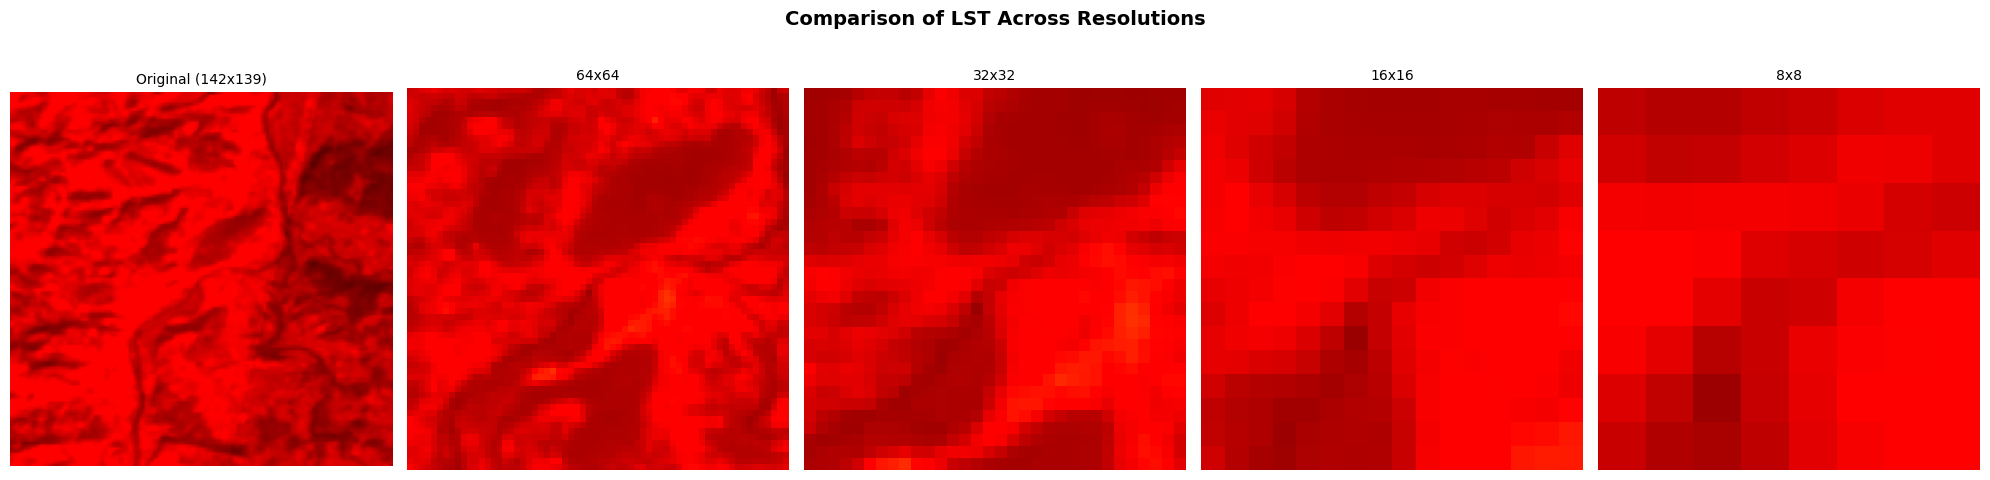

../data/preprocessed/64x64/ndvi/cell_1
['image_2024-04.tiff', 'image_2021-06.tiff', 'image_2022-06.tiff', 'image_2014-08.tiff', 'image_2023-08.tiff', 'image_2013-06.tiff', 'image_2013-04.tiff', 'image_2015-03.tiff']
../data/preprocessed/32x32/ndvi/cell_1
['image_2024-04.tiff', 'image_2021-06.tiff', 'image_2022-06.tiff', 'image_2014-08.tiff', 'image_2023-08.tiff', 'image_2013-06.tiff', 'image_2013-04.tiff', 'image_2015-03.tiff']
../data/preprocessed/16x16/ndvi/cell_1
['image_2024-04.tiff', 'image_2021-06.tiff', 'image_2022-06.tiff', 'image_2014-08.tiff', 'image_2023-08.tiff', 'image_2013-06.tiff', 'image_2013-04.tiff', 'image_2015-03.tiff']
../data/preprocessed/8x8/ndvi/cell_1
['image_2024-04.tiff', 'image_2021-06.tiff', 'image_2022-06.tiff', 'image_2014-08.tiff', 'image_2023-08.tiff', 'image_2013-06.tiff', 'image_2013-04.tiff', 'image_2015-03.tiff']


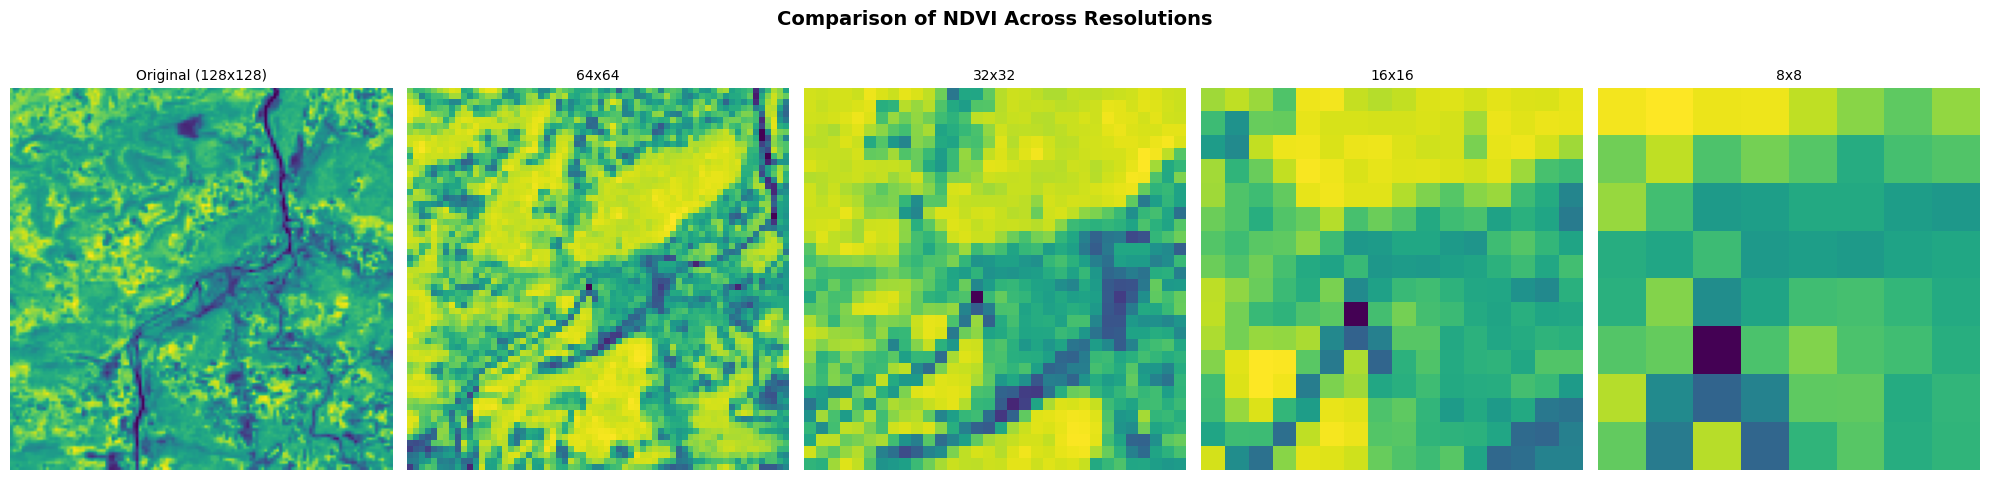

../data/preprocessed/64x64/slope/cell_1
['cell_1.tiff']


IndexError: list index out of range

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt

def enhance_contrast(img, clip_min=0.05, clip_max=0.95):
    """
    Enhance contrast by limiting the range and normalizing.
    Adjust `clip_min` and `clip_max` for softer contrast changes.
    """
    lower, upper = np.percentile(img, [clip_min * 100, clip_max * 100])
    img = np.clip(img, lower, upper)
    return (img - lower) / (upper - lower)

# List of input variables
inputs = ['lst', 'ndvi', 'slope', 'altitude', 'direction']

# Loop through variables
for variable in inputs:
    # Determine if the image is RGB
    rgb = variable == 'lst'
    
    # Initialize a list to store the images for plotting
    images = []
    titles = []
    
    # Load the original image
    or_folder = f'../data/preprocessed/{variable}/cell_1'
    original_img, _ = load_raster(os.path.join(or_folder, os.listdir(or_folder)[0]), rgb)
    images.append(original_img)
    titles.append(f'Original ({original_img.shape[1]}x{original_img.shape[0]})')  # Add dimensions to title
    
    # Load cropped images for all resolutions
    for crop_size in [64, 32, 16, 8]:
        new_folder = f'../data/preprocessed/{crop_size}x{crop_size}/{variable}/cell_1'
        print(new_folder)
        print( os.listdir(new_folder))
        new_img, _ = load_raster(os.path.join(new_folder, os.listdir(new_folder)[3]), rgb)
        images.append(new_img)
        titles.append(f'{crop_size}x{crop_size}')
    
    # Plot all images in a single row
    fig, ax = plt.subplots(1, len(images), figsize=(20, 5))  # Adjust figsize for clarity
    for i, img in enumerate(images):

        if variable=='lst':
            ax[i].imshow(enhance_contrast(img), cmap='viridis' if not rgb else None)
        else:
            ax[i].imshow(np.clip(img * (6 / 255), 0, 1), cmap='viridis' if not rgb else None)
        ax[i].set_title(titles[i], fontsize=10)
        ax[i].axis('off')

    
    # Add a central title for the row
    fig.suptitle(f'Comparison of {variable.upper()} Across Resolutions', fontsize=14, weight='bold')
    
    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'../plots/{variable}_resolution_comparison.png', dpi=300)
    plt.show()


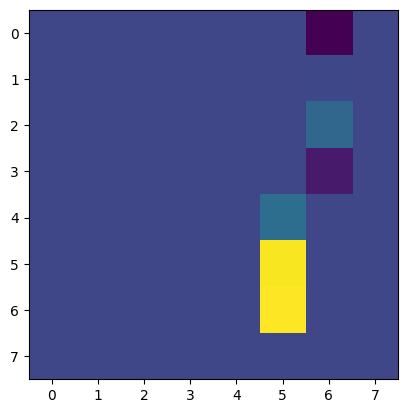

In [8]:
cut,mm=  load_raster('../data/preprocessed/8x8/slope/cell_21/cell_21.tiff',False)
#original,m = load_raster('../data/preprocessed/discharge/cell_67/cell_67.tif',False)
plt.imshow(cut)
plt.show()

In [89]:
mm.bounds

BoundingBox(left=2666070.1111025596, bottom=1268288.6415979539, right=2667989.8568402207, top=1270208.3864669106)

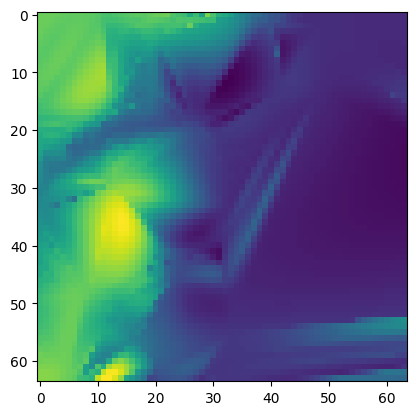

BoundingBox(left=2665301.4629068165, bottom=1267489.9977364542, right=2668788.5010631154, top=1270977.0343148329)

In [24]:
cut,mm=  load_raster('../data/preprocessed/altitude/cell_20.tif',False)
#original,m = load_raster('../data/preprocessed/discharge/cell_67/cell_67.tif',False)
plt.imshow(cut)
plt.show()
mm.bounds

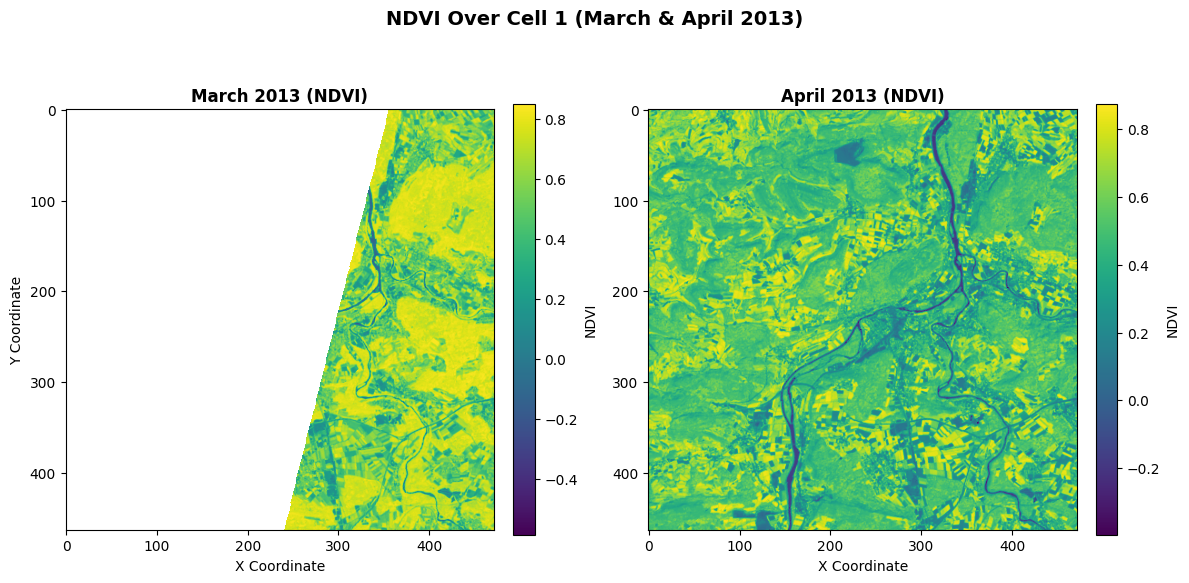

In [15]:
cut,mm=  load_raster('../data/raw/ndvi/cell_1/ndvi_2013-03.tiff',False)
cut2,mm=  load_raster('../data/raw/ndvi/cell_1/ndvi_2013-04.tiff',False)
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns for better horizontal layout

# Display the first image with title and labels
im1 = ax[0].imshow(cut, cmap='viridis')  # Use a colormap to make NDVI values visually intuitive
ax[0].set_title('March 2013 (NDVI)', fontsize=12, weight='bold')
ax[0].set_xlabel('X Coordinate', fontsize=10)
ax[0].set_ylabel('Y Coordinate', fontsize=10)
plt.colorbar(im1, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04, label='NDVI')

# Display the second image with title and labels
im2 = ax[1].imshow(cut2, cmap='viridis')
ax[1].set_title('April 2013 (NDVI)', fontsize=12, weight='bold')
ax[1].set_xlabel('X Coordinate', fontsize=10)
plt.colorbar(im2, ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04, label='NDVI')

# Add a central title for the entire figure
fig.suptitle('NDVI Over Cell 1 (March & April 2013)', fontsize=14, weight='bold', y=0.95)

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Reserve space for suptitle

# Save and show the figure
plt.savefig('../plots/preprocess_show.png', dpi=300)  # Save at high resolution
plt.show()


# Pixel wise dataset creation

### Raster masks

Bounds for cell_37: [2627066.54110279 1118941.95336085 2640985.71263633 1132861.11854738]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_37


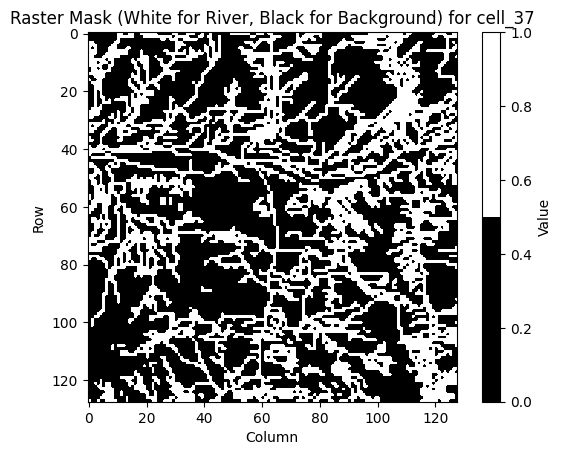

6128
Bounds for cell_8: [2750780.87158389 1227620.2907106  2762610.47968351 1241574.55750319]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_8


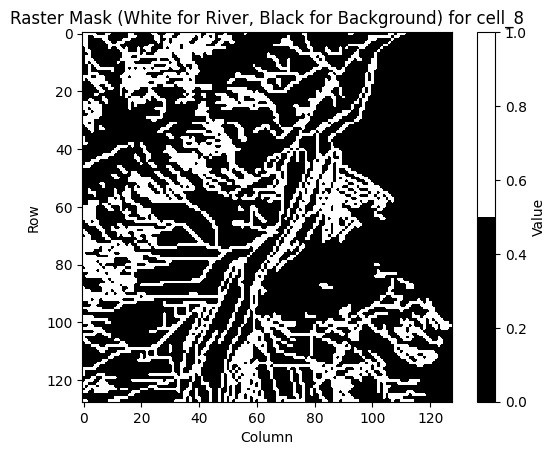

4861
Bounds for cell_33: [2586377.82533914 1186081.34626823 2600300.30365875 1200003.81829127]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_33


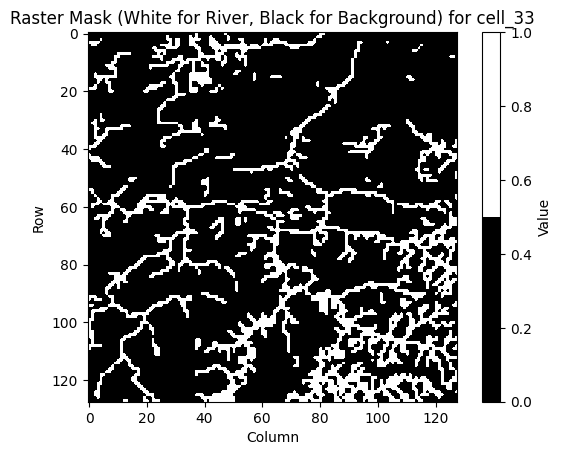

3092
Bounds for cell_9: [2485394.28547592 1109635.08712941 2493545.52428299 1119278.04743357]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_9


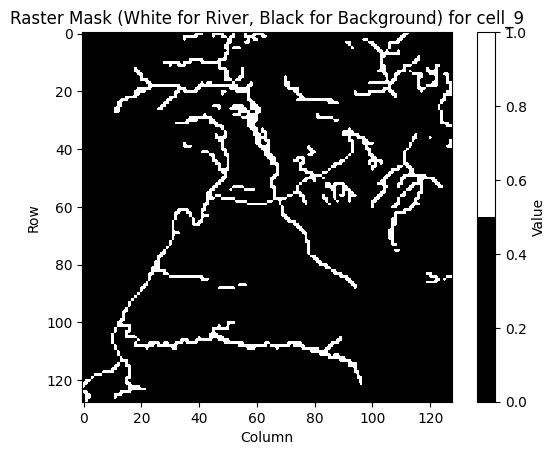

1336
Bounds for cell_42: [2788816.86210531 1158932.17238049 2802767.28332073 1172882.58717871]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_42


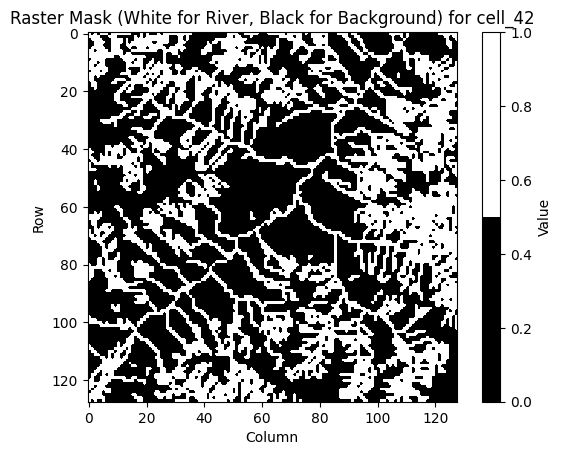

6452
Bounds for cell_78: [2597851.80712877 1185717.31744749 2611776.32047779 1199641.82449536]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_78


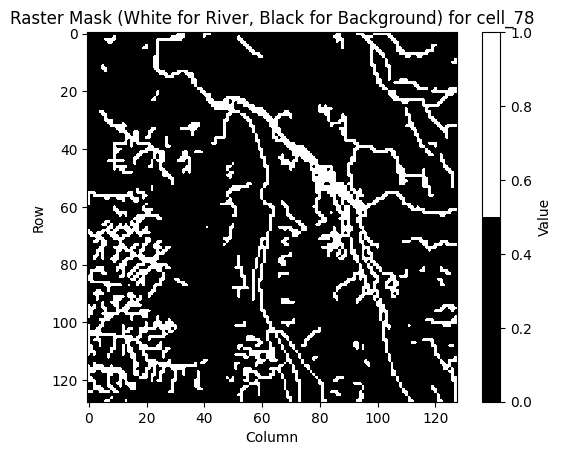

2733
Bounds for cell_6: [2639084.55648717 1260508.11099889 2653029.41617011 1271907.22765843]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_6


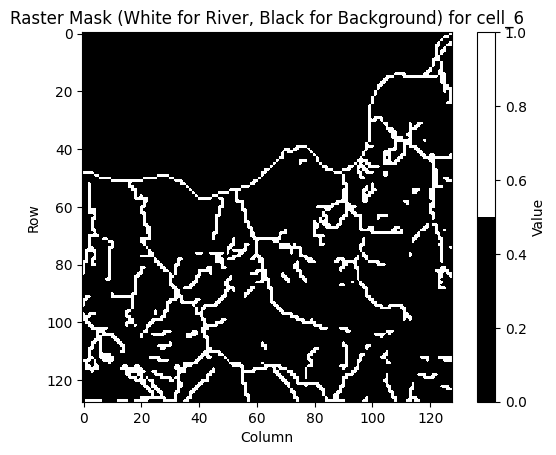

1708
Bounds for cell_46: [2565590.71659701 1237494.31141783 2579519.31535053 1251422.90391386]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_46


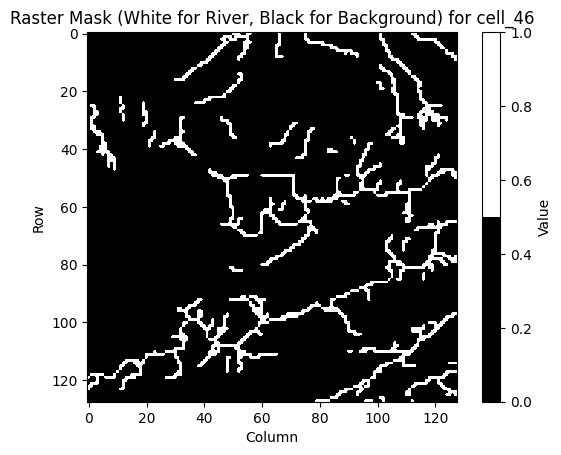

1502
Bounds for cell_31: [2758408.45043498 1197938.83044189 2772359.62328283 1211889.9968962 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_31


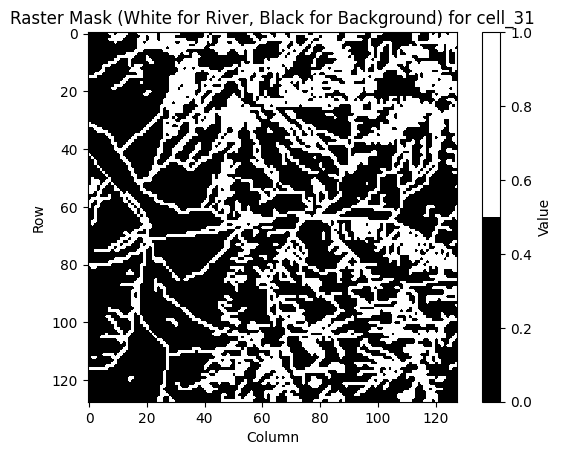

6003
Bounds for cell_59: [2596033.08643687 1195511.60893957 2609959.02225082 1209437.53845517]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_59


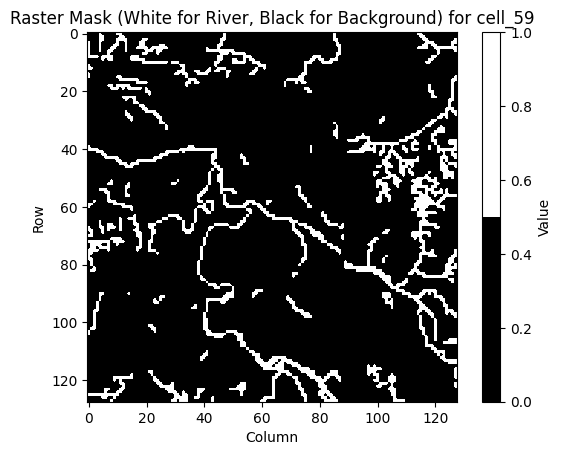

1870
Bounds for cell_63: [2525072.58841548 1149326.98514098 2538975.62789048 1161118.15532581]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_63


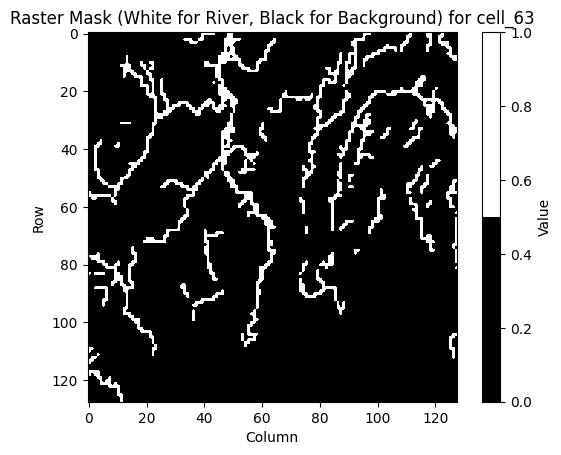

1552
Bounds for cell_11: [2581254.85740019 1212055.41088318 2595181.22153303 1225981.76873779]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_11


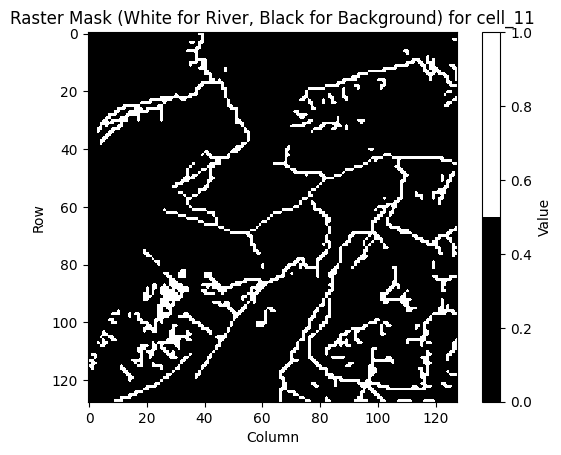

1817
Bounds for cell_36: [2623759.24652903 1200306.74951638 2637690.84758824 1214238.34426244]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_36


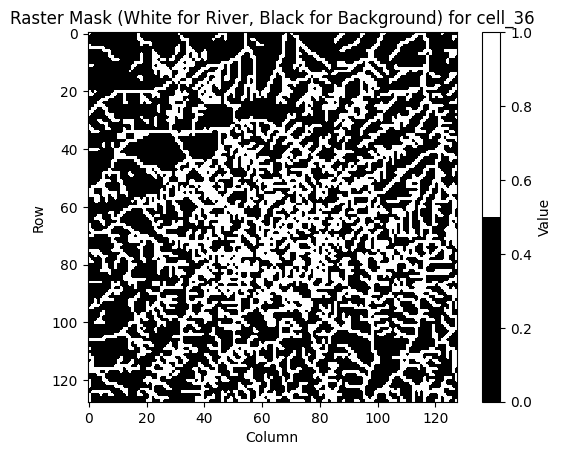

6324
Bounds for cell_65: [2781822.10843111 1144718.40955209 2795770.06648123 1158666.36118403]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_65


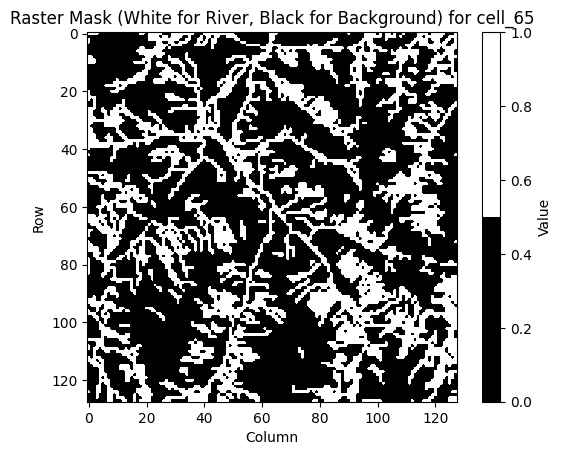

5511
Bounds for cell_56: [2682163.2809247  1275010.8128678  2696116.65480634 1288964.18041926]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_56


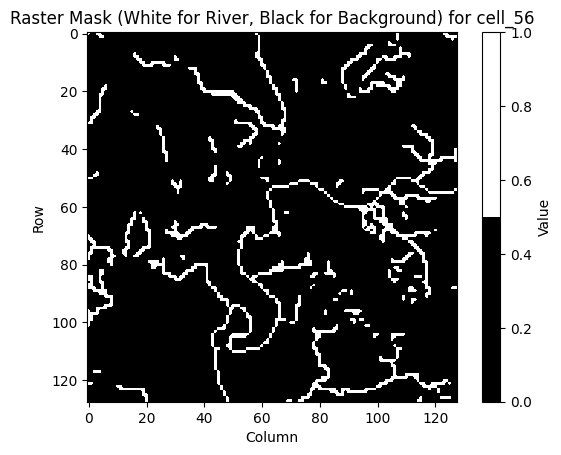

1354
Bounds for cell_12: [2678535.73386719 1189082.17580992 2692474.37222473 1203020.80781476]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_12


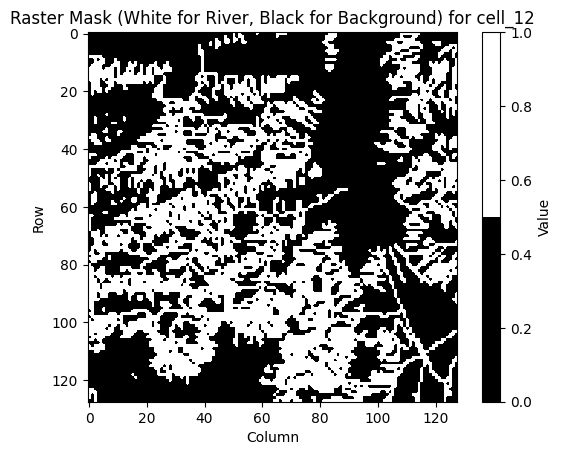

6601
Bounds for cell_72: [2503121.36571067 1133136.90387211 2516672.54849862 1147032.41391121]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_72


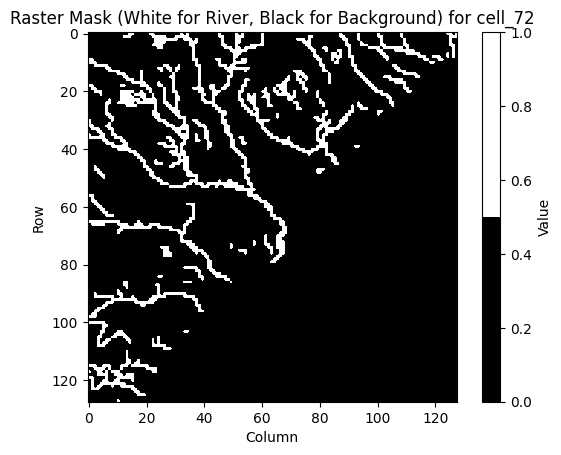

1539
Bounds for cell_24: [2742058.69032779 1237239.12772708 2756013.30861971 1251193.73964242]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_24


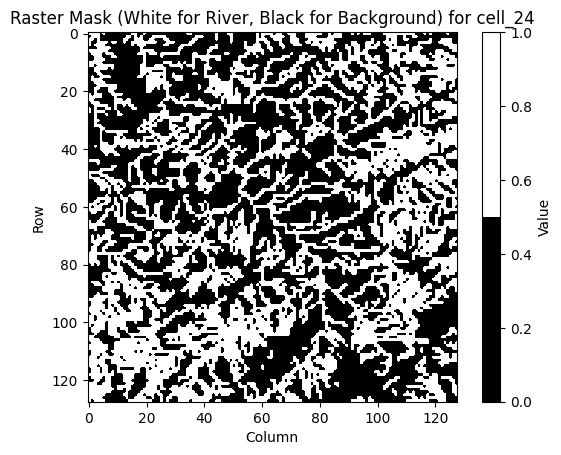

7315
Bounds for cell_38: [2538492.62179302 1173914.17221067 2552403.53982029 1187825.08397066]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_38


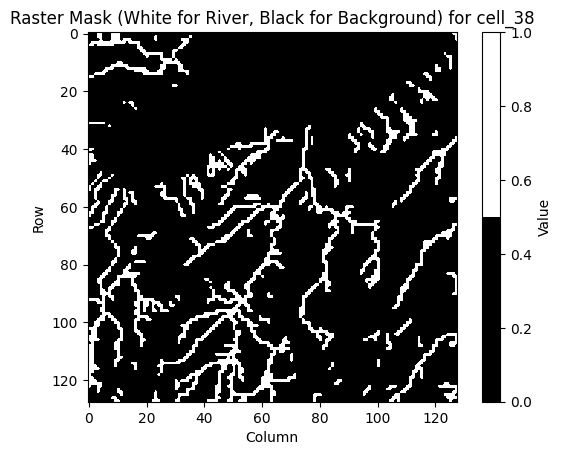

1990
Bounds for cell_80: [2554713.37920808 1180361.92214104 2568628.76681631 1194277.30347414]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_80


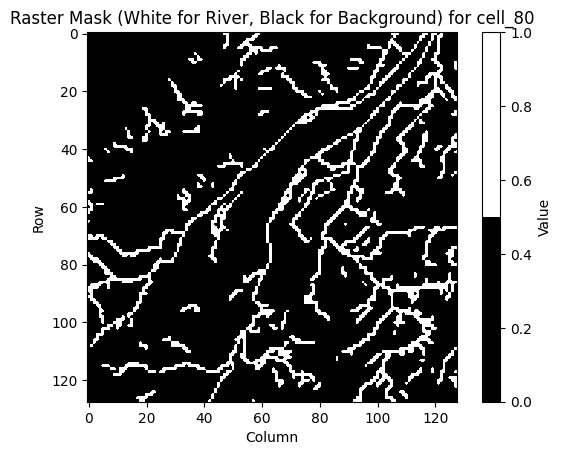

2194
Bounds for cell_25: [2601734.24418987 1141332.70322886 2615651.96998269 1155250.4226994 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_25


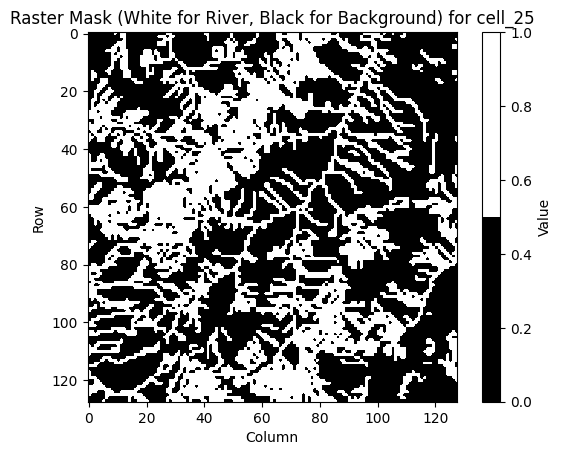

6645
Bounds for cell_21: [2658676.96287329 1251711.4904193  2672623.02336698 1265657.54459247]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_21


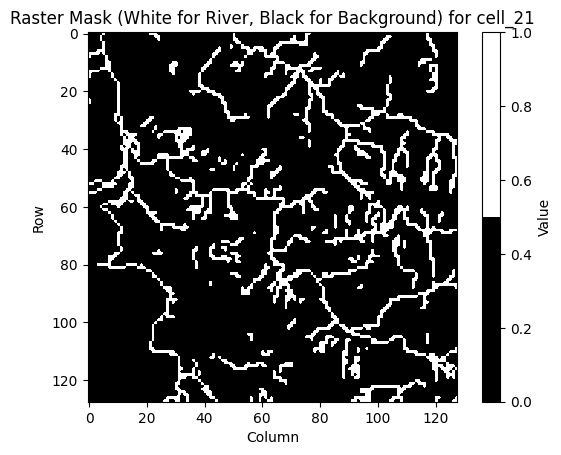

2179
Bounds for cell_68: [2626768.01086206 1164545.47255099 2640694.15311289 1178471.60847355]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_68


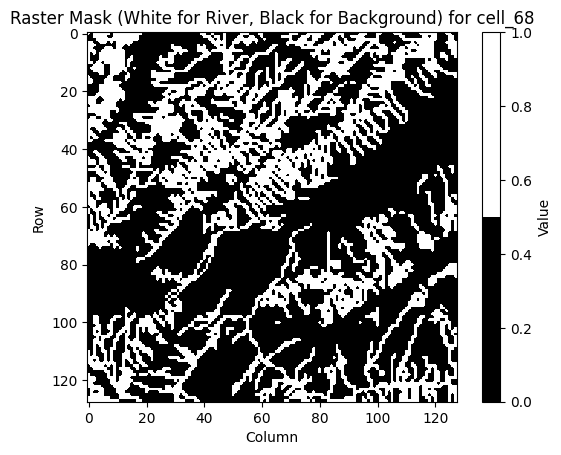

5537
Bounds for cell_32: [2622614.29035072 1212171.80718115 2636547.7806229  1226105.29114536]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_32


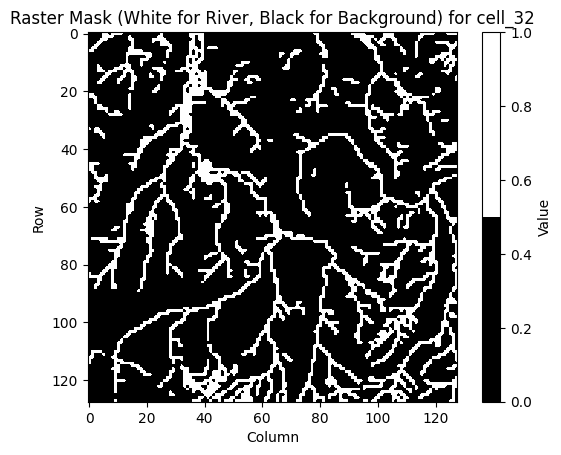

3089
Bounds for cell_10: [2655862.71374987 1245605.23717842 2669807.2850706  1259549.80217843]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_10


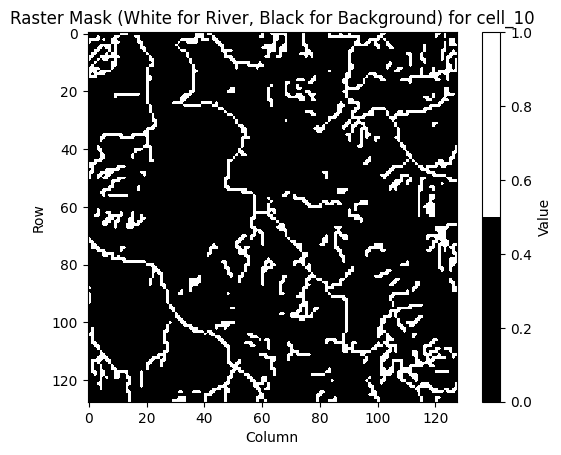

2145
Bounds for cell_61: [2726580.14560012 1256207.61747763 2740535.8187514  1270163.28426541]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_61


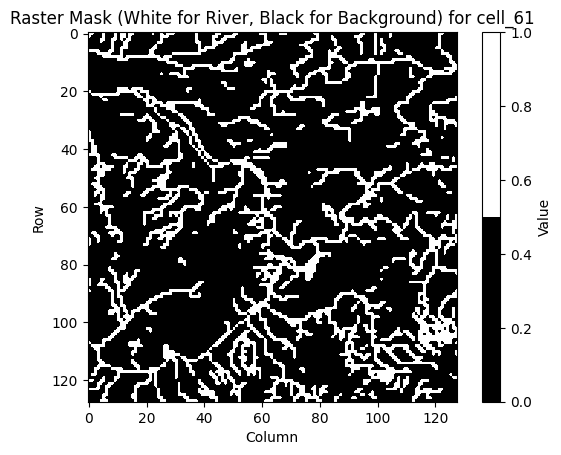

3397
Bounds for cell_17: [2593762.69849071 1191034.21818456 2607687.41941702 1204958.93281396]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_17


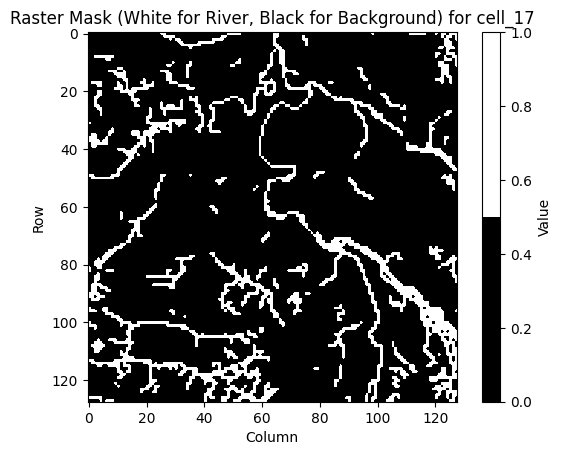

2227
Bounds for cell_14: [2686523.84630739 1265530.36405784 2700476.10731137 1279482.61872806]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_14


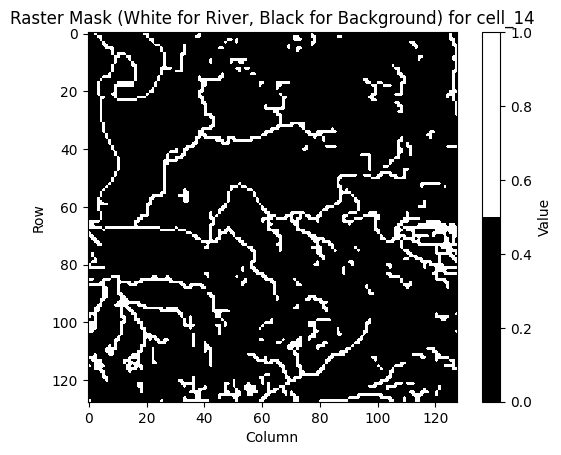

1894
Bounds for cell_18: [2680439.82680905 1270170.35502292 2694392.11881684 1284122.6406995 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_18


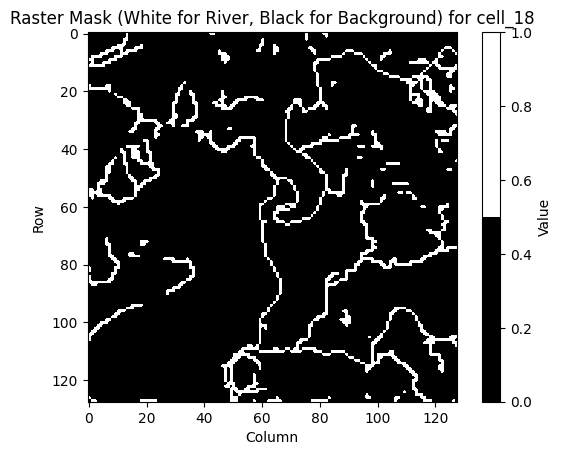

1465
Bounds for cell_1: [2649986.52401692 1252381.06002334 2663931.46256555 1266325.99225707]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_1


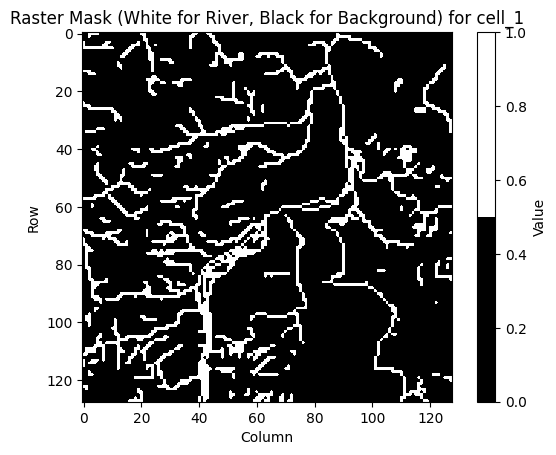

2264
Bounds for cell_71: [2578144.01980506 1192232.55468704 2592066.09862688 1206154.62722251]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_71


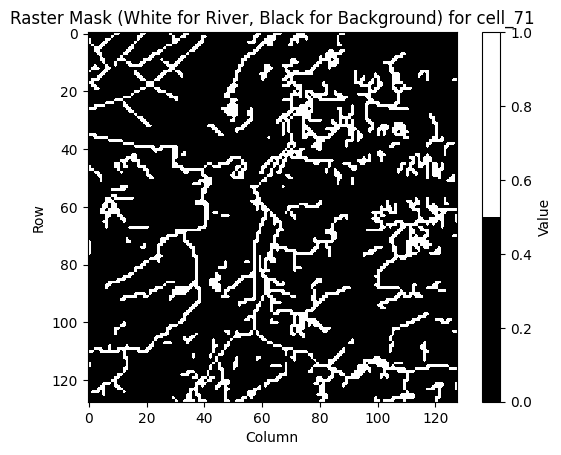

2650
Bounds for cell_45: [2718198.92561716 1214411.35955028 2732147.12301956 1228359.55058495]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_45


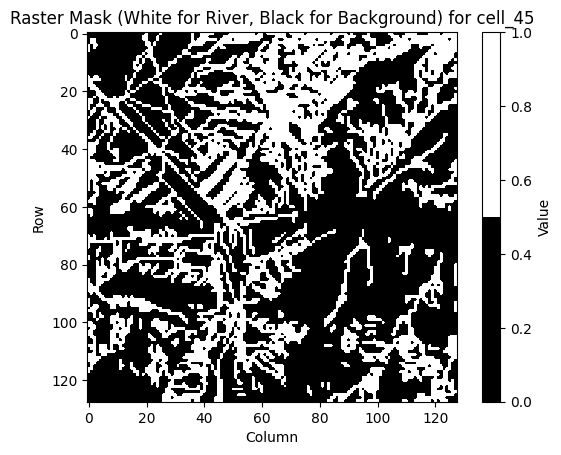

5886
Bounds for cell_23: [2681296.73413141 1199199.18456515 2695237.35147193 1213139.79555613]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_23


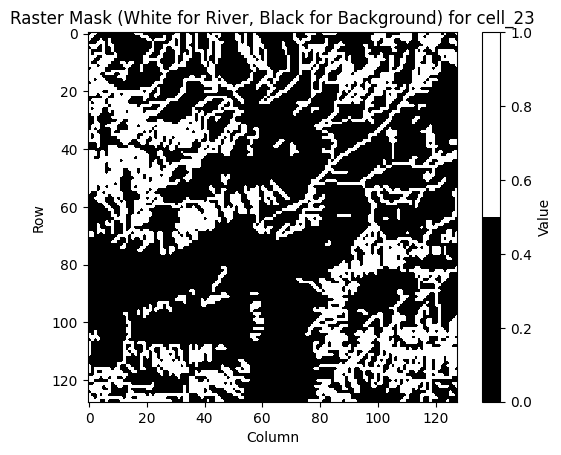

5233
Bounds for cell_28: [2550696.73177902 1126332.22027479 2564601.52090682 1140237.00310366]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_28


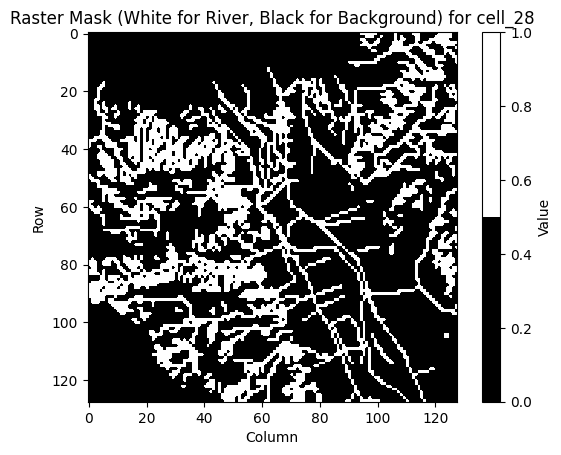

4506
Bounds for cell_60: [2760214.62917161 1250830.06512052 2768745.72568098 1263578.10611496]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_60


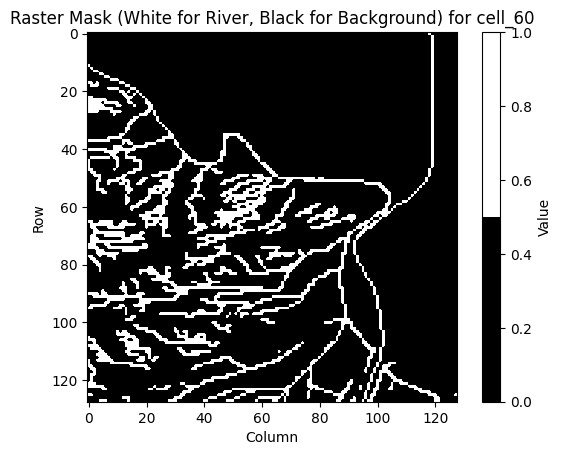

2273
Bounds for cell_19: [2693753.87802538 1211155.3302863  2707698.18163554 1225099.62754285]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_19


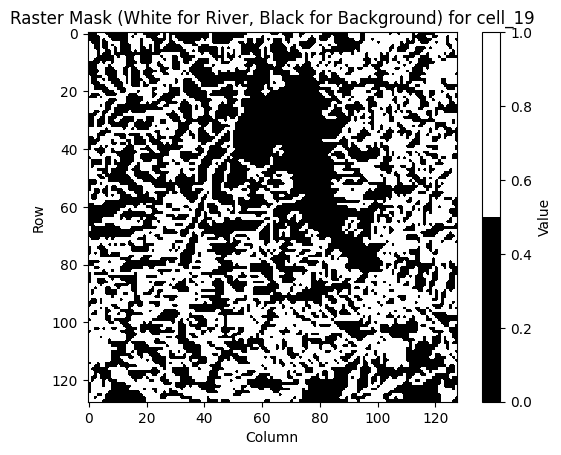

7947
Bounds for cell_43: [2652993.96454582 1256130.50194349 2666940.01406776 1270076.54515001]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_43


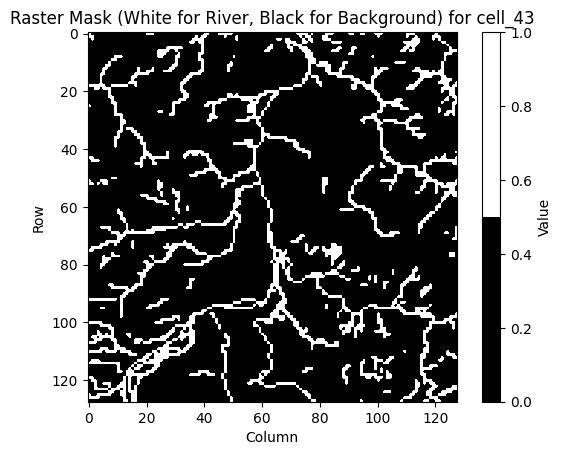

2356
Bounds for cell_35: [2706678.09969657 1106535.42705897 2720610.16441894 1120467.48538837]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_35


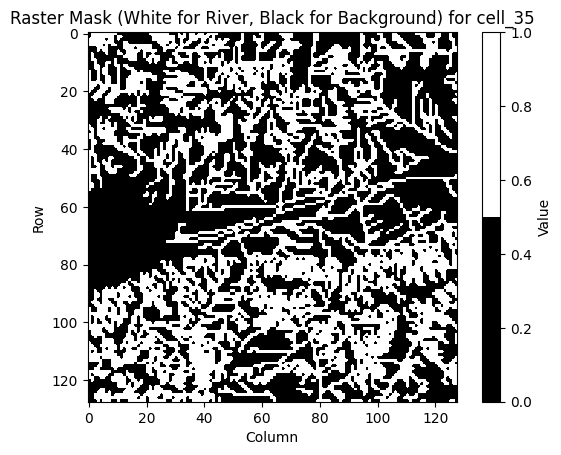

7083
Bounds for cell_20: [2660070.90626373 1262259.44401583 2674019.05890267 1276207.59033576]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_20


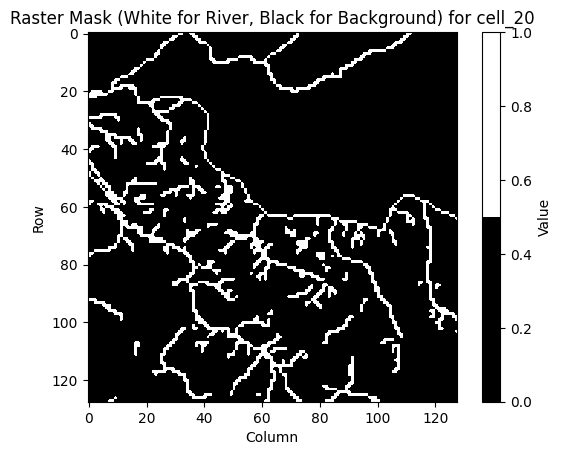

1632
Bounds for cell_58: [2693777.86822811 1211258.32057931 2707722.19122484 1225202.63722254]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_58


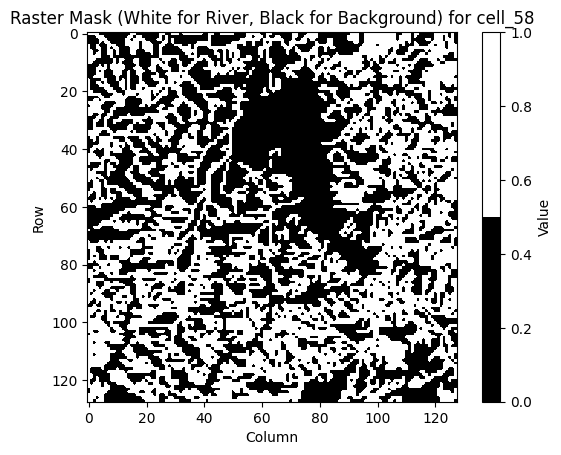

7984
Bounds for cell_57: [2711849.24135931 1241472.71037022 2725800.75495659 1255424.21761013]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_57


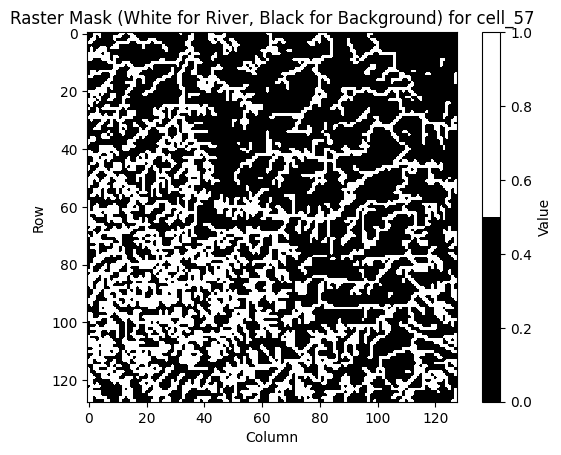

6038
Bounds for cell_7: [2691667.63994434 1216063.09939362 2705612.41041199 1230007.86350963]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_7


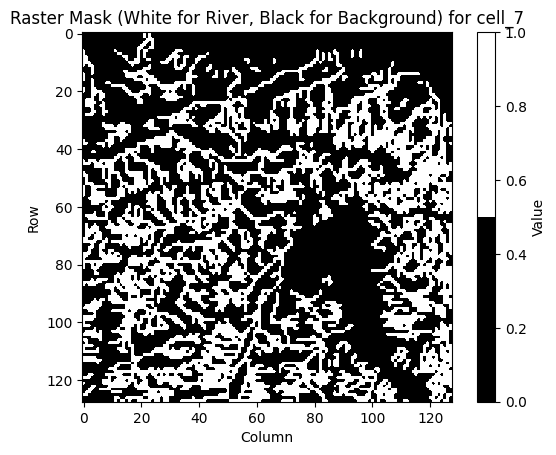

5930
Bounds for cell_41: [2690255.7214862  1216306.1824609  2704200.32865503 1230250.78327965]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_41


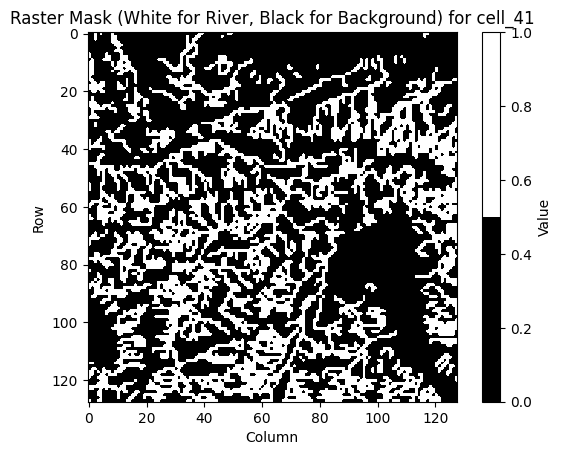

5619
Bounds for cell_73: [2567713.7885182  1254249.99667135 2574810.62038256 1261430.39417613]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_73


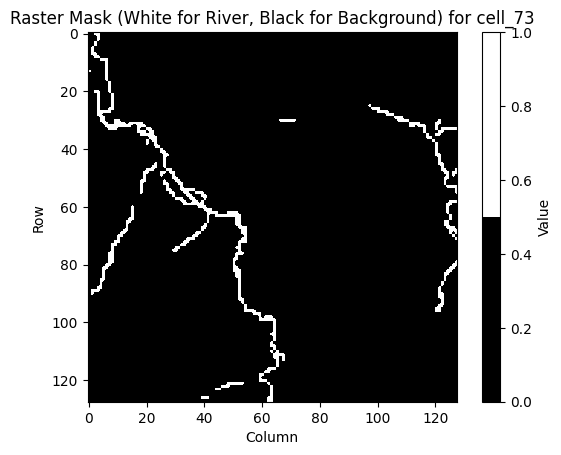

541
Bounds for cell_64: [2652168.21481705 1264862.76242141 2666115.74673903 1276278.47815331]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_64


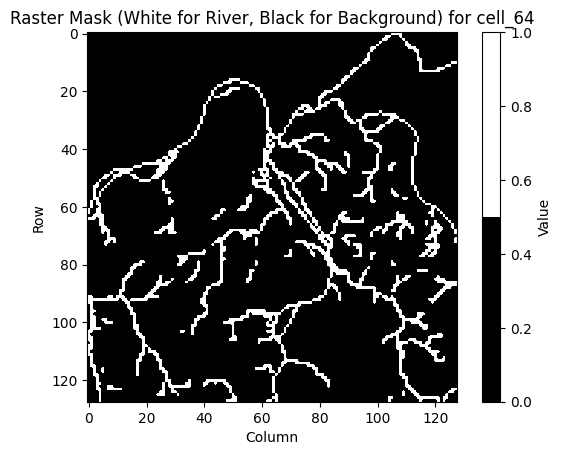

1707
Bounds for cell_26: [2586787.14196277 1111676.58247931 2600697.13316372 1125586.56735339]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_26


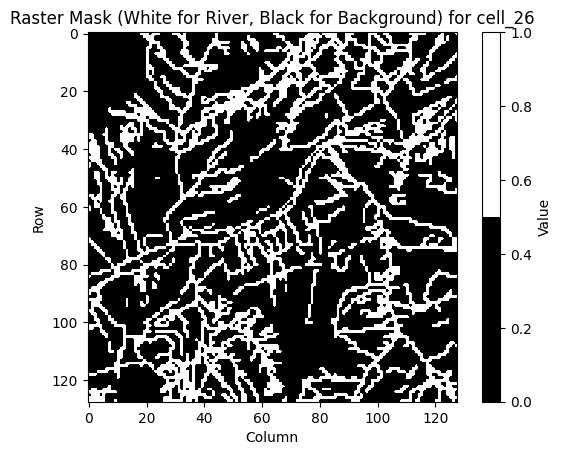

4696
Bounds for cell_49: [2704369.20868077 1085179.01944634 2716545.59556663 1099107.89709724]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_49


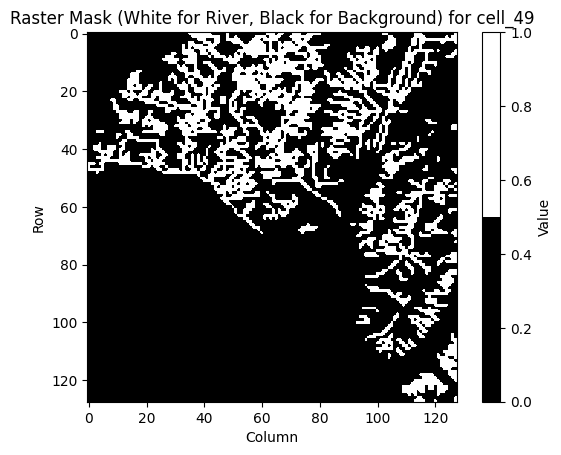

3216
Bounds for cell_5: [2616651.45436237 1193461.95629029 2630580.65454428 1207391.1501614 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_5


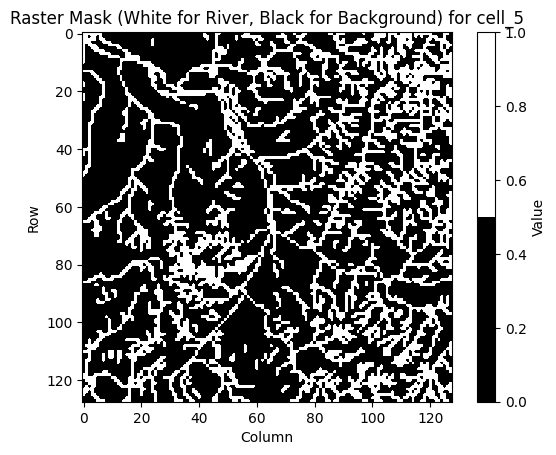

4968
Bounds for cell_27: [2779248.47547652 1176394.81334505 2793199.63707439 1190345.9685332 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_27


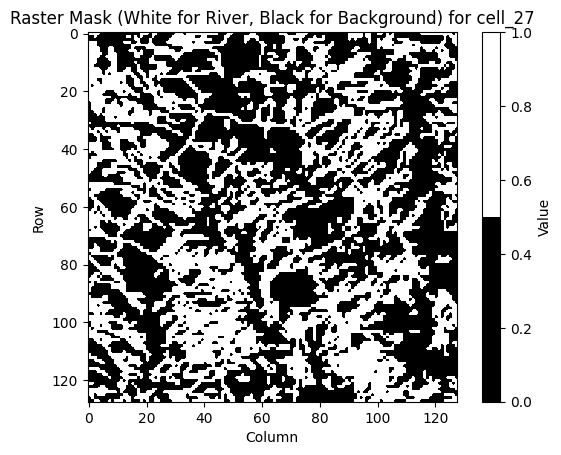

7247
Bounds for cell_15: [2620217.91888805 1260874.49055314 2634160.0566762  1270997.99016125]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_15


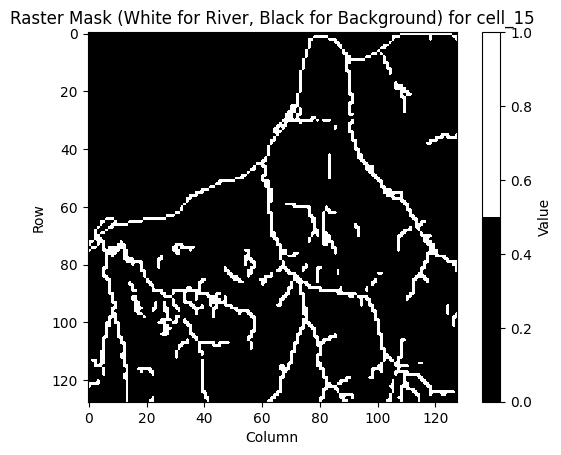

1426
Bounds for cell_44: [2701081.93871245 1116990.28241733 2715014.3057222  1130922.64303942]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_44


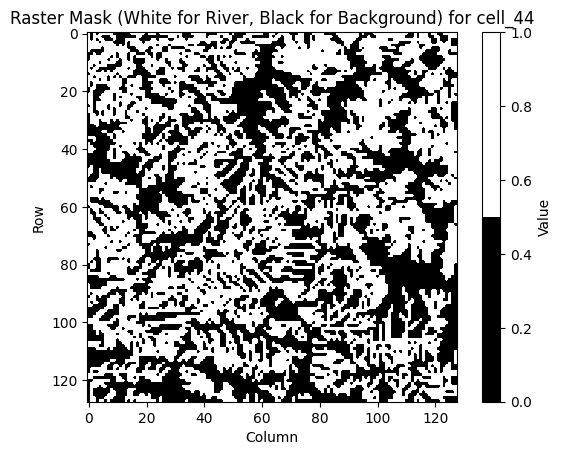

8819
Bounds for cell_50: [2746155.13561915 1254552.58819931 2760112.82825882 1268510.27446254]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_50


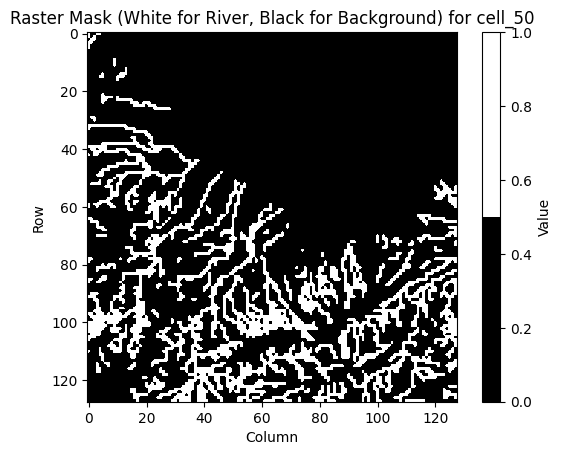

3001
Bounds for cell_76: [2492945.66226981 1110906.1857371  2506834.6306747  1124795.14787344]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_76


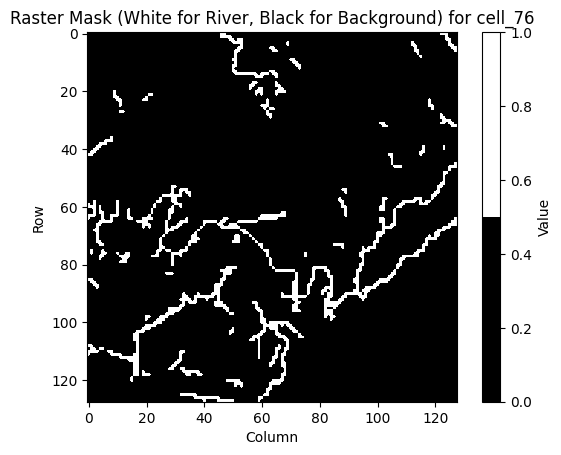

1061
Bounds for cell_55: [2626177.33385829 1161228.79249627 2640102.83675503 1175154.2890641 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_55


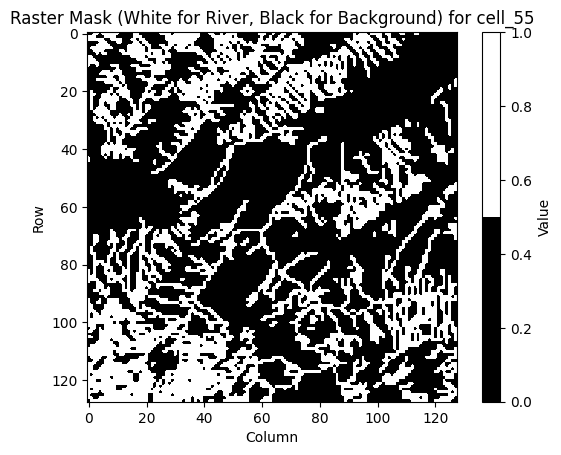

5712
Bounds for cell_40: [2707121.45693021 1254751.94459845 2721074.51403072 1268704.99534621]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_40


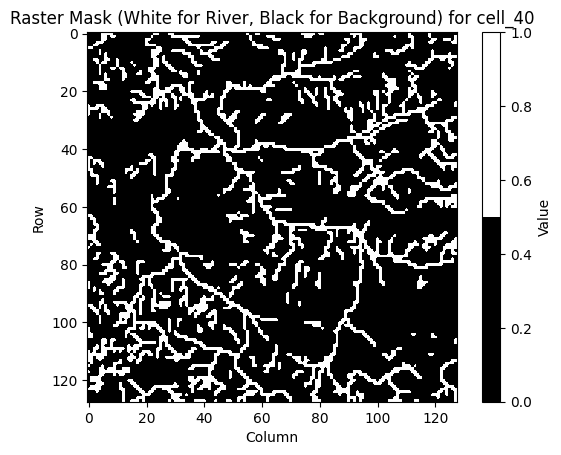

3167
Bounds for cell_79: [2651588.03379717 1211283.52384687 2665526.03350718 1225221.51722911]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_79


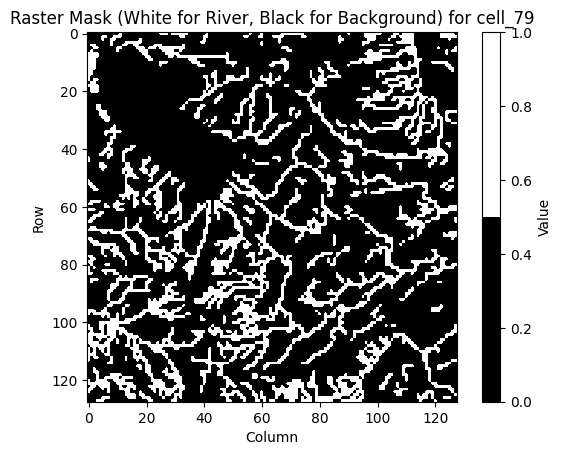

3928
Bounds for cell_66: [2702563.07383802 1262703.57421836 2716516.88227804 1276657.3763121 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_66


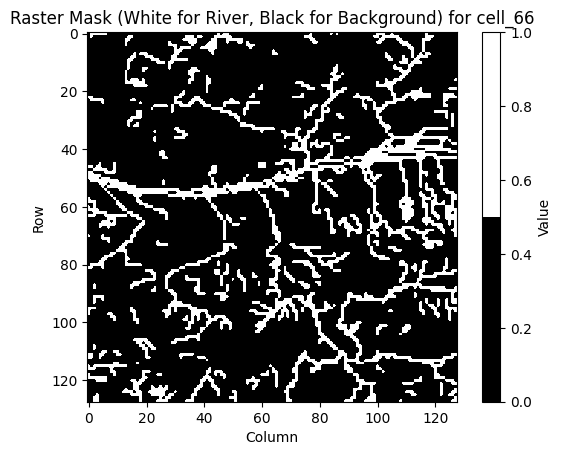

2879
Bounds for cell_16: [2642977.11362715 1170409.56716327 2656907.03584    1184339.48304016]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_16


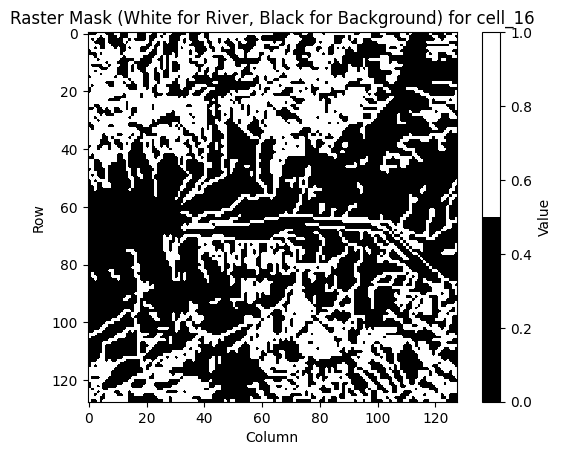

6503
Bounds for cell_13: [2666588.12963624 1195891.58963182 2680525.96523045 1209829.41888503]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_13


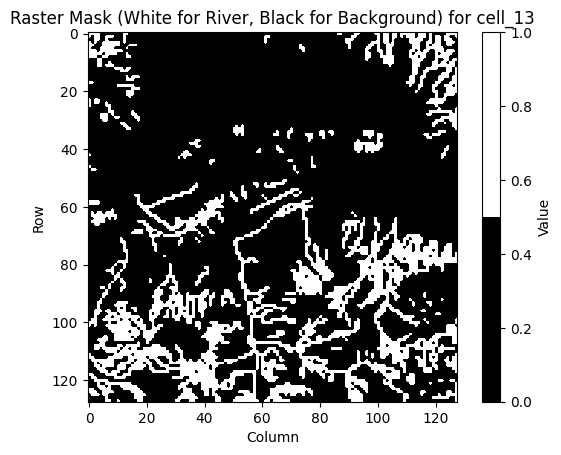

3420
Bounds for cell_69: [2759326.22690692 1243392.65555311 2768745.72568098 1257350.17882128]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_69


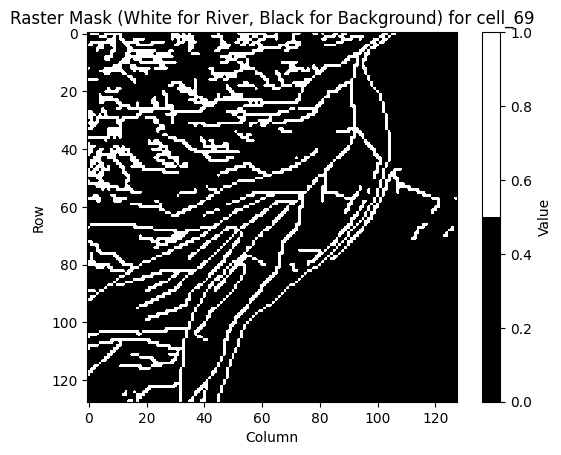

2646
Bounds for cell_67: [2494267.76102178 1110715.81212735 2508156.53702097 1122068.05013075]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_67


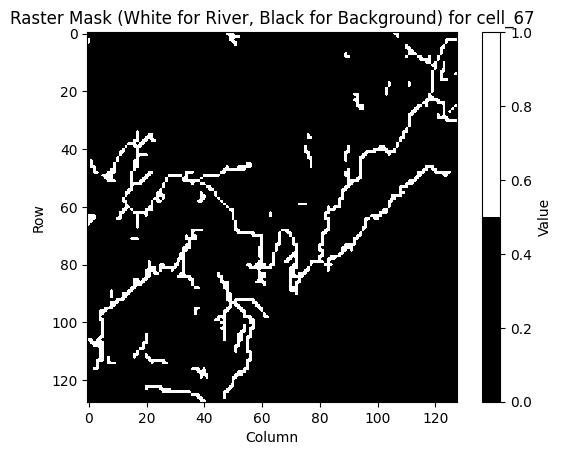

1041
Bounds for cell_74: [2683113.59539742 1186264.03019354 2697052.51541201 1200202.94385265]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_74


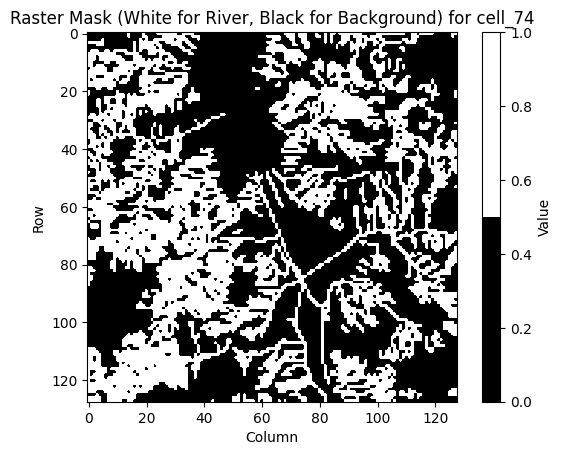

6763
Bounds for cell_48: [2720126.80592503 1240319.26628607 2734079.19109715 1254271.64509582]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_48


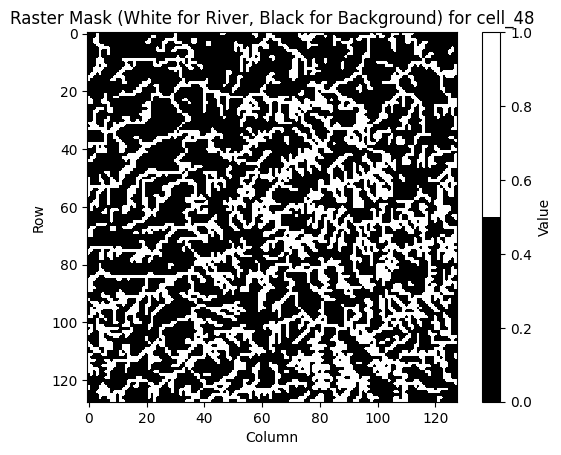

5653
Bounds for cell_53: [2606273.2149618  1172317.70332937 2620196.93744983 1186241.41950438]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_53


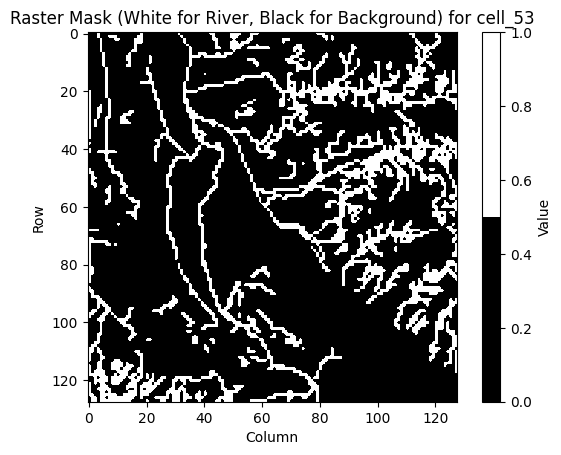

3210
Bounds for cell_75: [2671071.11237074 1262741.64085604 2685020.84972746 1276691.37188664]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_75


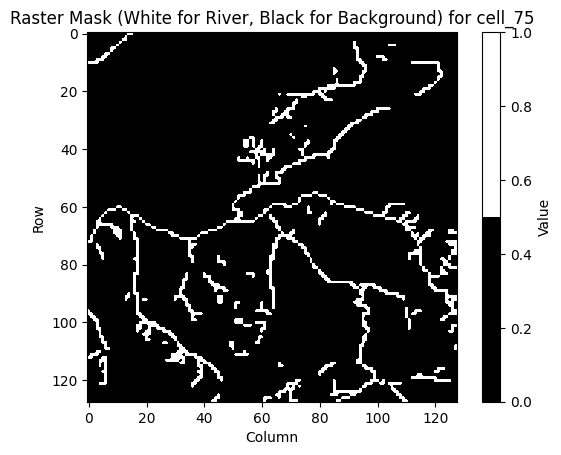

1240
Bounds for cell_3: [2622167.86925912 1133959.30208198 2636088.35577355 1147879.7822594 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_3


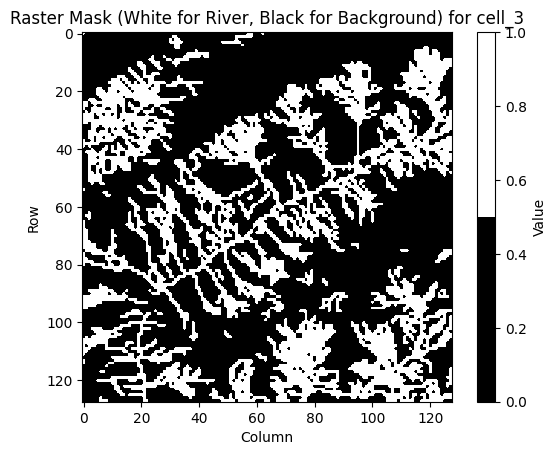

5347
Bounds for cell_70: [2678017.14451065 1128989.52190589 2691947.08034025 1142919.45136744]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_70


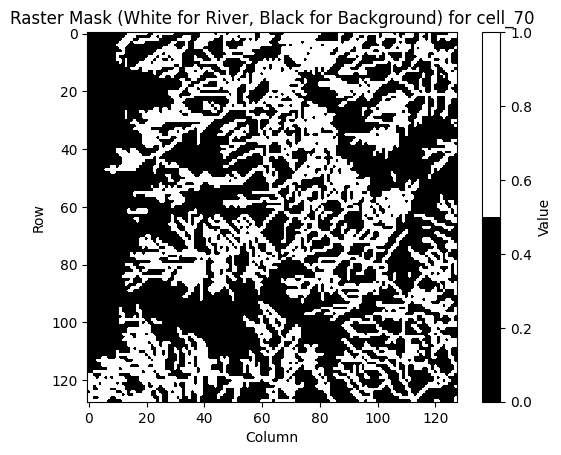

6422
Bounds for cell_54: [2795138.70844898 1135037.98705624 2809087.48323993 1148986.75542166]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_54


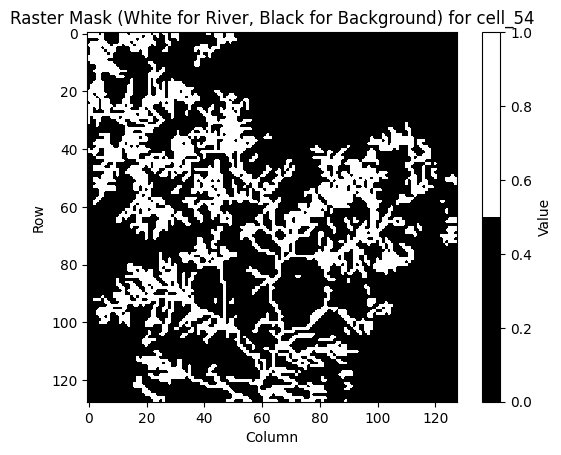

4115
Bounds for cell_30: [2606601.43474565 1256115.01334075 2620540.55279754 1270054.12510998]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_30


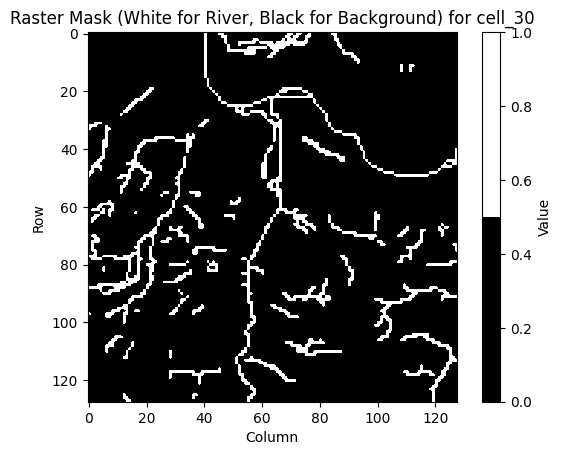

1448
Bounds for cell_2: [2726589.14819697 1111194.46268115 2739598.6007008  1125130.41122918]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_2


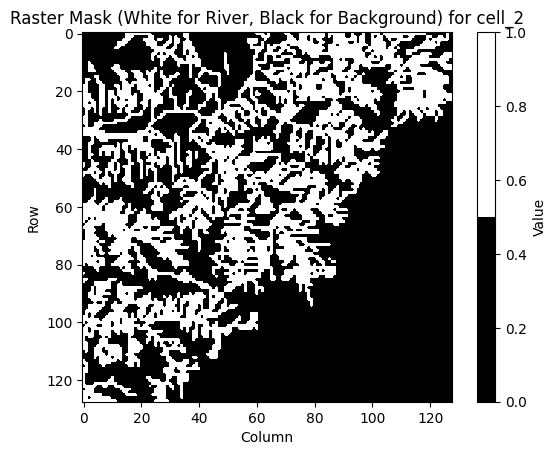

5564
Bounds for cell_52: [2658366.04522477 1204823.52223524 2672304.03354973 1218761.50422635]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_52


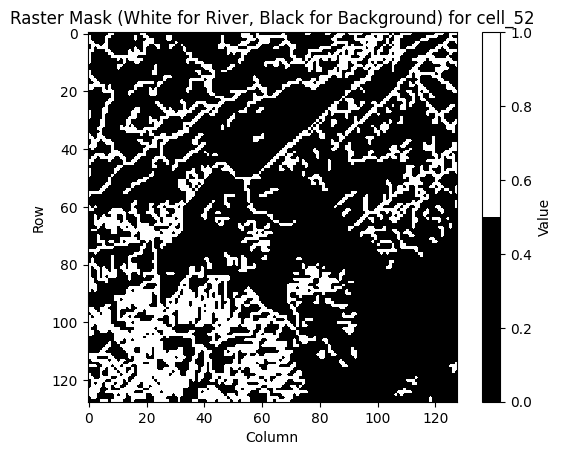

4439
Bounds for cell_51: [2656729.01830596 1206687.49879385 2670667.05709924 1220625.53125496]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_51


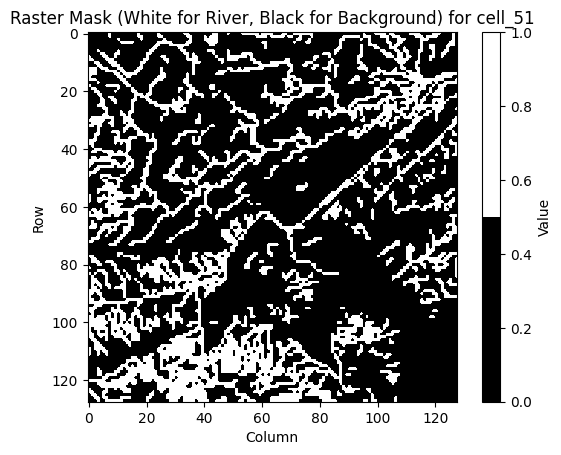

4539
Bounds for cell_81: [2636732.77369296 1130330.18956211 2650655.45589005 1144252.86541166]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_81


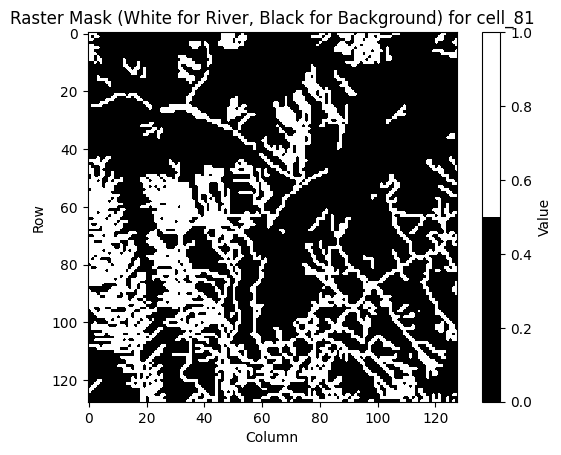

4789
Bounds for cell_62: [2717011.26221401 1210993.69349848 2730958.79340577 1224941.218323  ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_62


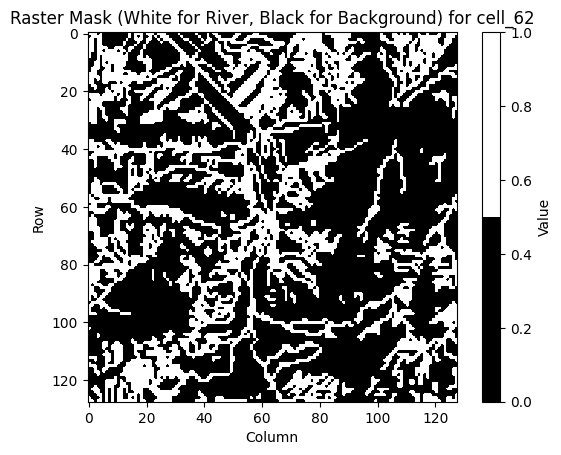

5609
Bounds for cell_34: [2823822.5376251  1161728.81942877 2833363.68575632 1175683.87115827]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_34


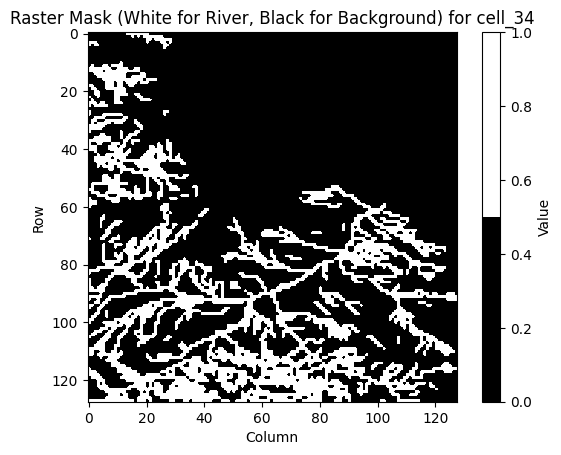

3728
Bounds for cell_39: [2513772.46836378 1143997.55109069 2527583.65850806 1154359.29341959]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_39


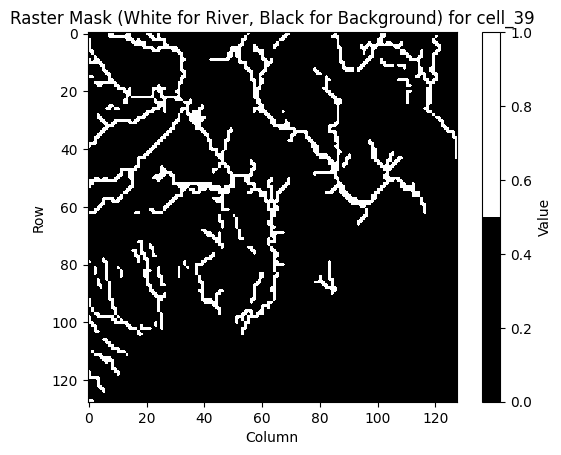

1584
Bounds for cell_29: [2662892.17829379 1147112.58883856 2676822.01349886 1161042.4176876 ]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_29


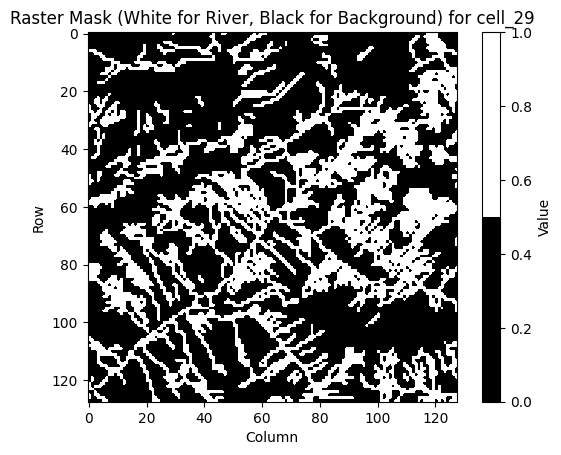

5477
Bounds for cell_47: [2572859.79538453 1220381.36530098 2586786.26877253 1234263.58316393]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_47


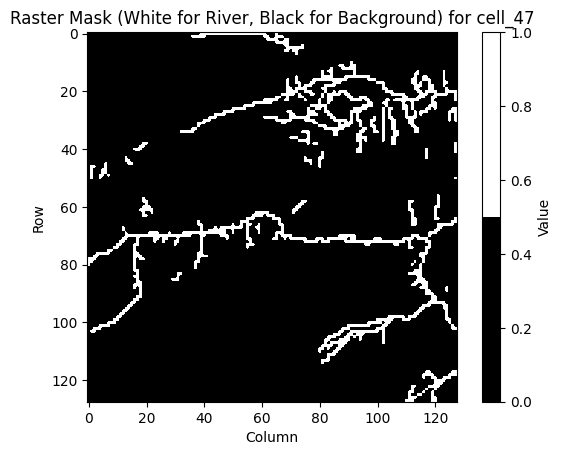

1235
Bounds for cell_4: [2728026.04312307 1175063.42553965 2741970.08153694 1189007.45757055]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_4


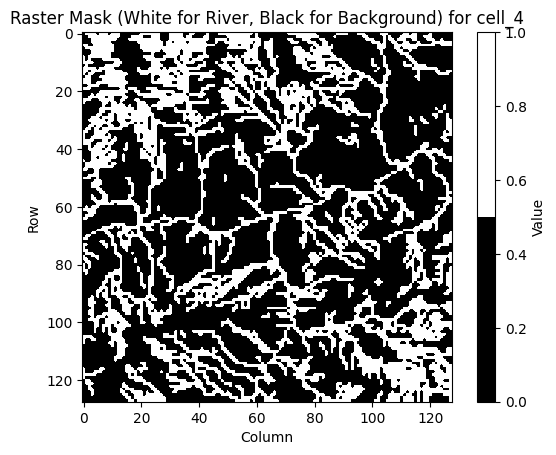

5607
Bounds for cell_22: [2573713.24708501 1204688.79932467 2587636.84771512 1218612.39367594]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_22


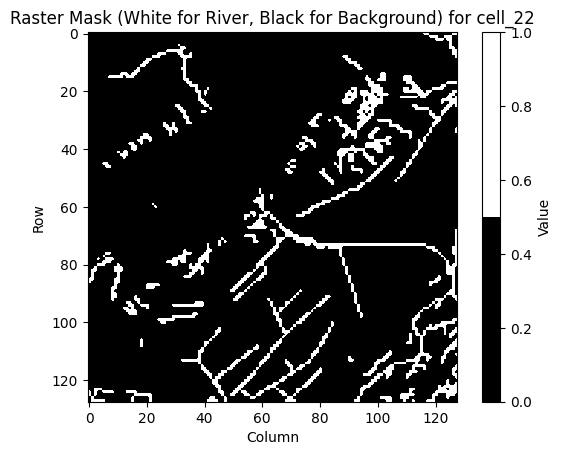

1525
Bounds for cell_77: [2604761.65587151 1265346.24608976 2618702.31387228 1271770.71216631]
Min value: 0.0
Max value: 1.0
shape: (128, 128)
done cell_77


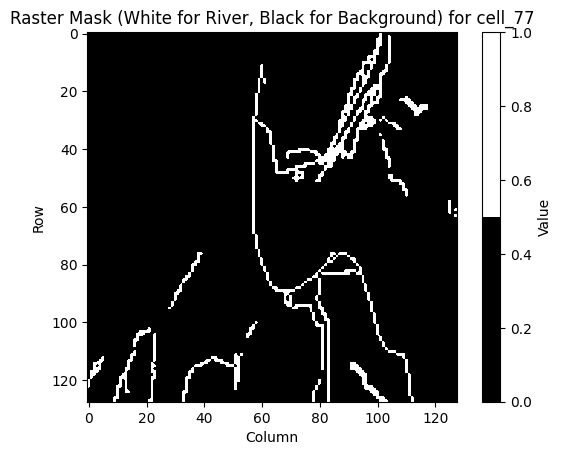

887


In [9]:
os.makedirs('../data/external/raster_masks/', exist_ok=True)
clear_directory('../data/external/raster_masks/')
# Desired output size
output_shape = (128, 128)
binary_masks = []
for k, river in river_cells.items():
    river_original = river.to_crs('EPSG:2056')

    # Check the bounds of the filtered river geometries
    x_min, y_min, x_max, y_max = list(river_original.total_bounds)
    print(f"Bounds for {k}: {river_original.total_bounds}")
    
    # Create the transform for 256x256 grid based on the bounds
    grid_width = output_shape[1]  # 256 pixels for width
    grid_height = output_shape[0]  # 256 pixels for height
    x_res = (x_max - x_min) / grid_width
    y_res = (y_max - y_min) / grid_height

    transform = from_origin(x_min, y_max, x_res, y_res)

    # Convert the LineStrings to a list of geometries for rasterization
    line_geometries = river_original.geometry.values

    # Create a raster mask for the output shape (256x256)
    out_shape = output_shape
    raster_array = np.zeros(out_shape)

    # Rasterize each LineString into the grid
    for i, geom in enumerate(line_geometries):
        if geom.is_empty:
            print(f"Empty geometry for {k}, skipping.")
            continue
        shape = (geom, 1)  # Assign a value of 1 for each line
        temp_mask = rasterize([shape], out_shape=out_shape, transform=transform)
        raster_array += temp_mask

    # Binarize the raster
    binary_mask = np.where(raster_array > 0.0, 1.0, 0.0)
    print(f"Min value: {binary_mask.min()}")
    print(f"Max value: {binary_mask.max()}")
    print('shape:', binary_mask.shape)
    binary_masks.append(binary_mask)
    print('done', k)

    # Define a colormap (black for background, white for river)
    cmap = plt.cm.colors.ListedColormap(['black', 'white'])
    
    # Display the rasterized mask with a custom colormap
    plt.imshow(binary_mask, cmap=cmap)
    plt.colorbar(label='Value')
    plt.title(f'Raster Mask (White for River, Black for Background) for {k}')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()
    print(len(np.nonzero(binary_mask.reshape(-1))[0]))

    # Save the raster
    save_raster(raster_array, f'../data/external/raster_masks/raster_mask_bw_{k}.tif', river)


In [47]:
dir_path = '../data/external/raster_masks/'
files = os.listdir(dir_path)
river_masks = {}
river_masks_expanded = {}
for raster in files:
    cl_int=raster.split('bw_cell_')[-1].split('.')[0]
    cc = raster.split('bw_')[-1].split('.')[0]
    raster_path = os.path.join(dir_path, raster)
    rast,meta = load_raster(raster_path,False)
    river_masks[cc]=rast
    river_mask_expanded = np.expand_dims(rast, axis=-1)  # Expande para tener forma (height, width, 1)
    river_mask_expanded = np.repeat(river_mask_expanded, total_data['lst'].shape[-1], axis=-1)  # Expande a (height, width, 3)
    river_masks_expanded[cc] = river_mask_expanded
    

(128, 128)


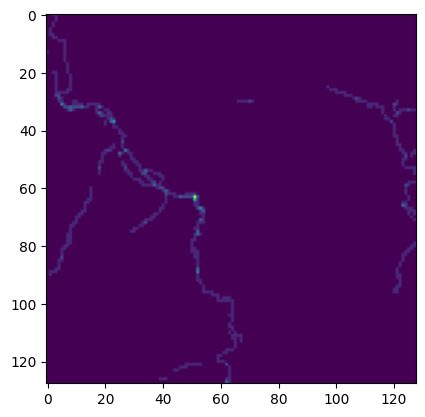

In [35]:
plt.imshow(river_masks['cell_73'])
print(river_masks['cell_73'].shape)

<Axes: >

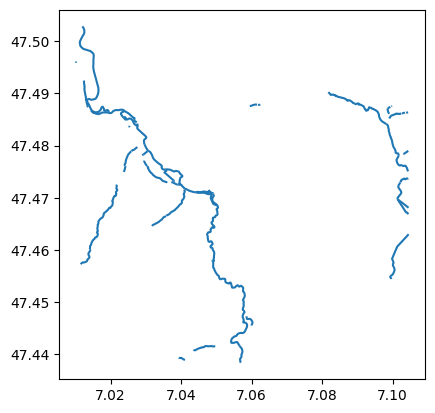

In [36]:
river_mask['cell_73'].reshape

### LST and NDVI dataset

In [5]:
from collections import Counter
imgs_per_river = Counter(labels) 

In [11]:
imgs_per_river['cell_78']

0

In [12]:
import os
import numpy as np
import pandas as pd
from rasterio.features import rasterize

def process_river_data(total_data, total_times, river_masks, imgs_per_river, data_type, output_subdir, source_path='../data/preprocessed/'):
    """
    Process LST or NDVI data for rivers and save it as CSV files.

    Parameters:
        total_data (dict): Dictionary containing the image data (LST or NDVI).
        total_times (dict): Dictionary containing the timestamps for each image.
        river_masks (dict): Dictionary containing the river masks for each cell.
        imgs_per_river (dict): Dictionary with the number of images per river.
        data_type (str): Type of data to process ('lst' or 'ndvi').
        output_subdir (str): Subdirectory for saving CSV files (e.g., 'lst' or 'ndvi').
        source_path (str): Base directory for saving the output.
    """
    last = 0  # Track the starting index for each river
    for i, (cell, im_per_river) in enumerate(imgs_per_river.items()):
        print(f"Processing cell {cell} ({i + 1} of {len(imgs_per_river)})...",im_per_river)
        try:
            # Get the river mask and indices
            river_mask = river_masks[cell]
            cell_gdf = river_cells[cell]
            x_min, y_min, x_max, y_max = cell_gdf.total_bounds
            target_width, target_height = 128, 128
            transform = from_bounds(x_min, y_min, x_max, y_max, target_width, target_height)
        
            array = rasterize(
                [(geom, 1) for geom in cell_gdf.geometry],
                out_shape=(target_height, target_width),
                transform=transform,
                fill=0,  # Valor para áreas fuera de las geometrías
                dtype="float32"
            )
            river_indices = np.nonzero(array.reshape(-1))[0]

            # Initialize a DataFrame to store pixel values for this cell
            pixel_ds = pd.DataFrame(columns=river_indices)

            # Process images for this river cell
            for count in range(im_per_river):
                ind = count + last
                image = total_data[data_type][ind]

                # Flatten image and extract river pixel values
                if data_type == 'lst':  # Convert LST RGB to grayscale if needed
                    img_gray = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
                    flat_image = img_gray.flatten()
                else:  # NDVI doesn't need conversion
                    flat_image = image.flatten()

                river_image = flat_image[river_indices]
                pixel_ds.loc[total_times[data_type][ind]] = river_image

            # Update the starting index for the next river
            last += im_per_river

            # Save to CSV
            csv_dir = f"{source_path}{output_subdir}/{cell}/"
            os.makedirs(csv_dir, exist_ok=True)
            csv_path = f"{csv_dir}{cell}.csv"
            if os.path.exists(csv_path):
                os.remove(csv_path)
            pixel_ds.to_csv(csv_path)
            print(f"Saved: {csv_path}")

        except KeyError as e:
            print(f"KeyError for cell {cell}: {e}")
            continue


In [14]:
# Process LST data
process_river_data(
    total_data=total_data,
    total_times=total_times,
    river_masks=river_cells,  # Or river_masks if available
    imgs_per_river=imgs_per_river,
    data_type='lst',
    output_subdir='lst'
)

# Process NDVI data
process_river_data(
    total_data=total_data,
    total_times=total_times,
    river_masks=river_cells,
    imgs_per_river=imgs_per_river,
    data_type='ndvi',
    output_subdir='ndvi'
)


Processing cell cell_67 (1 of 74)... 13
Saved: ../data/preprocessed/lst/cell_67/cell_67.csv
Processing cell cell_2 (2 of 74)... 15
Saved: ../data/preprocessed/lst/cell_2/cell_2.csv
Processing cell cell_31 (3 of 74)... 32
Saved: ../data/preprocessed/lst/cell_31/cell_31.csv
Processing cell cell_19 (4 of 74)... 19
Saved: ../data/preprocessed/lst/cell_19/cell_19.csv
Processing cell cell_29 (5 of 74)... 24
Saved: ../data/preprocessed/lst/cell_29/cell_29.csv
Processing cell cell_71 (6 of 74)... 39
Saved: ../data/preprocessed/lst/cell_71/cell_71.csv
Processing cell cell_49 (7 of 74)... 9
Saved: ../data/preprocessed/lst/cell_49/cell_49.csv
Processing cell cell_43 (8 of 74)... 17
Saved: ../data/preprocessed/lst/cell_43/cell_43.csv
Processing cell cell_10 (9 of 74)... 15
Saved: ../data/preprocessed/lst/cell_10/cell_10.csv
Processing cell cell_13 (10 of 74)... 28
Saved: ../data/preprocessed/lst/cell_13/cell_13.csv
Processing cell cell_41 (11 of 74)... 16
Saved: ../data/preprocessed/lst/cell_41/ce

In [103]:
pixel_ds_lst

0     1     2          18         19         21         22     \
2019-08  20.521967   0.0   0.0  20.521967  20.521967  20.521967  20.521967   
2013-07  20.237665   0.0   0.0  20.237665  20.237665  20.237665  20.237665   
2013-08   2.100885   0.0   0.0   2.100885   2.100885   2.100885   2.100885   
2013-12   3.944910   0.0   0.0   3.944910   3.944910   3.944910   3.944910   
2014-01   8.486841   0.0   0.0   8.486841   8.486841   8.486841   8.486841   
2014-03  14.074945   0.0   0.0  14.074945  14.074945  14.074945  14.074945   
2014-05  19.286921   0.0   0.0  19.286921  19.286921  19.286921  19.286921   
2014-06   7.832971   0.0   0.0   7.832971   7.832971   7.832971   7.832971   
2014-11  14.357203   0.0   0.0  14.357203  14.357203  14.357203  14.357203   
2015-05  20.728327   0.0   0.0  20.728327  20.728327  20.728327  20.728327   
2015-08   4.520624   0.0   0.0   4.520624   4.520624   4.520624   4.520624   
2016-02   5.997400   0.0   0.0   5.997400   5.997400   5.997400   5.997400   
2016-03  20.406397   0.0   0.0  20.406397  20.406397  20.406397  20.406397   
2016-07  18.477381   0.0   0.0  18.477381  18.477381  18.477381  18.477381   
2016-09  11.532801   0.0   0.0  11.532801  11.532801  11.532801  11.532801   
2017-04  15.367579   0.0   0.0  15.367579  15.367579  15.367579  15.367579   
2017-05  20.731195   0.0   0.0  20.731195  20.731195  20.731195  20.731195   
2017-06  14.895472   0.0   0.0  14.895472  14.895472  14.895472  14.895472   
2017-09  19.259607   0.0   0.0  19.259607  19.259607  19.259607  19.259607   
2018-06  21.940516   0.0   0.0  21.940516  21.940516  21.940516  21.940516   
2018-08  18.461878   0.0   0.0  18.461878  18.461878  18.461878  18.461878   
2018-09   3.618310   0.0   0.0   3.618310   3.618310   3.618310   3.618310   
2018-12   8.083490   0.0   0.0   8.083490   8.083490   8.083490   8.083490   
2019-03  20.662348   0.0   0.0  20.662348  20.662348  20.662348  20.662348   

             23    30    33     ... 65415 65416 65424 65425 65441 65442 65443  \
2019-08  20.521967   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-07  20.237665   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-08   2.100885   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-12   3.944910   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-01   8.486841   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-03  14.074945   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-05  19.286921   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-06   7.832971   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-11  14.357203   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2015-05  20.728327   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2015-08   4.520624   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2016-02   5.997400   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2016-03  20.406397   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2016-07  18.477381   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2016-09  11.532801   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2017-04  15.367579   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2017-05  20.731195   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2017-06  14.895472   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2017-09  19.259607   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-06  21.940516   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-08  18.461878   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-09   3.618310   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-12   8.083490   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2019-03  20.662348   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

        65453      65482      65483 